# The Effects of a Changing Environment on the Spectra of Mars Analog Samples

This work constitutes the data analysis section for my MSc thesis at UCL (currently in progress, due August 2024). My project is advised by Dr Louisa Preston, with support from Professor Lewis Dartnell and Connor Ballard.

In this notebook, I will be analysing how lyophilization affects the spectra of Mars analog samples. This analysis includes:

* MIR spectra collected at the Mullard Space Science Laboratory using the Agilent 4300 Handheld FTIR spectrometer, docked onto a table-top setup and equipped with a Diamond-ATR sampling module.
* VNIR spectra collected at the University of Westminster using the RxSpec 700Z spectrometer. There are spectral joins in this data at $1000nm$ and $1830nm$, so features around these wavelengths should be disregarded in analysis. These wavelengths are indicated by dashed grey lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from scipy.signal import find_peaks

## Samples

I am analysing sandstone from Antarctica (denoting Antarctica crytoendolith sandstone as ACE SST) and <a href="https://doi.org/10.1016/j.icarus.2023.115568">SOPHIA</a> (Simulant for Oxia Planum: Hydrated, Igneous, and Amorphous). I also analyse the spectra for a microbial mat collected on the Robert Falcon Scott expedition to Antarctica in 1910. For the SOPHIA sample, I analyse the spectra with and without microbes from the mat mixed in. For each sample, I collected multiple spectra to analyse different parts of the sample. These are labeled as subsamples (SS). I label the samples as: 

* ACE SST BP5 - crustal layer of Antarctica sandstone sample from site BP5
* ACE SST BP6 - crustal layer of Antarctica sandstone sample from site BP6
* ACE SST BLACK - black layer of Antarctica sandstone sample
* SCOTT MAT - microbial mat from the Scott expedition
* SOPHIA - simulant
* SOPHIA MAT - simulant with microbial mat mixed in

In [2]:
BEFORE = '/Before Lyophilization'
AFTER = '/After Lyophilization'
MIR = '/MIR'
VNIR = '/VNIR'
EFFECTS = '/Lyophilization Effects'
COMPARISON = '/Comparison'
COMPARISON_ACE_SST = '/ACE SST'
COMPARISON_SOPHIA = '/SOPHIA'
VNIR_SPECTRAL_JOINS = [1000, 1830]

DATA_ROOT =  './Data'
DATA_MIR_BEFORE = DATA_ROOT + BEFORE + MIR
DATA_MIR_AFTER = DATA_ROOT + AFTER + MIR
DATA_VNIR_BEFORE = DATA_ROOT + BEFORE + VNIR
DATA_VNIR_AFTER = DATA_ROOT + AFTER + VNIR

SPECTRA_ROOT = './Spectra'
SPECTRA_MIR_BEFORE = SPECTRA_ROOT + BEFORE + MIR
SPECTRA_MIR_AFTER = SPECTRA_ROOT + AFTER + MIR
SPECTRA_VNIR_BEFORE = SPECTRA_ROOT + BEFORE + VNIR
SPECTRA_VNIR_AFTER = SPECTRA_ROOT + AFTER + VNIR
SPECTRA_EFFECTS = SPECTRA_ROOT + EFFECTS
SPECTRA_COMPARISON = SPECTRA_ROOT + COMPARISON

DATA_SKIP_ROWS_MIR_BEFORE=28
DATA_SKIP_FOOTER_MIR_BEFORE=0
DATA_SKIP_ROWS_MIR_AFTER=1
DATA_SKIP_FOOTER_MIR_AFTER=215
DATA_SKIP_ROWS_VNIR_BEFORE=1
DATA_SKIP_FOOTER_VNIR_BEFORE=50
DATA_SKIP_ROWS_VNIR_AFTER=1
DATA_SKIP_FOOTER_VNIR_AFTER=50

SAMPLE_COLORS_BEFORE = {
    'ACE SST BP5': 'DarkSlateBlue',
    'ACE SST BP6': 'MediumVioletRed',
    'ACE SST BLACK': 'Black',
    'SCOTT MAT': 'ForestGreen',
    'SOPHIA': 'SaddleBrown',
    'SOPHIA MAT': 'FireBrick',
}
SAMPLE_COLORS_AFTER = {
    'ACE SST BP5': 'CornflowerBlue',
    'ACE SST BP6': 'LightCoral',
    'ACE SST BLACK': 'LightSlateGrey',
    'SCOTT MAT': 'SpringGreen',
    'SOPHIA': 'SandyBrown',
    'SOPHIA MAT': 'Crimson',
}

In [3]:
def load_spectra(fileName):
    delimiter = '\t'
    if (fileName.endswith('.csv')):
        delimiter = ','

    skiprows = 0
    skipfooter = 0
    if (DATA_MIR_BEFORE in fileName):
        skiprows = DATA_SKIP_ROWS_MIR_BEFORE
        skipfooter = DATA_SKIP_FOOTER_MIR_BEFORE
    elif (DATA_MIR_AFTER in fileName):
        skiprows = DATA_SKIP_ROWS_MIR_AFTER
        skipfooter = DATA_SKIP_FOOTER_MIR_AFTER
    elif (DATA_VNIR_BEFORE in fileName):
        skiprows = DATA_SKIP_ROWS_VNIR_BEFORE
        skipfooter = DATA_SKIP_FOOTER_VNIR_BEFORE
    elif (DATA_VNIR_AFTER in fileName):
        skiprows = DATA_SKIP_ROWS_VNIR_AFTER
        skipfooter = DATA_SKIP_FOOTER_VNIR_AFTER

    result = np.loadtxt(fileName, delimiter=delimiter, skiprows=skiprows)
    result = np.transpose(result)

    if (skipfooter != 0):
        result = [result[0][0:-skipfooter], result[1][0:-skipfooter]]

    return result

In [4]:
def load_selected_spectra(dir, ss):
    subsample = listdir(dir)[ss - 1]

    return load_spectra(fileName=dir + '/' + subsample)

In [5]:
def load_subsamples_spectra(dir):
    result = {}

    for sample in listdir(dir):
        result[sample] = []
        
        for subsample in listdir(dir + '/' + sample):
            result[sample].append(load_spectra(fileName=dir + '/' + sample + '/' + subsample))

    return result

In [6]:
BEFORE_MIR = load_subsamples_spectra(dir=DATA_MIR_BEFORE)
AFTER_MIR = load_subsamples_spectra(dir=DATA_MIR_AFTER)
BEFORE_VNIR = load_subsamples_spectra(dir=DATA_VNIR_BEFORE)
AFTER_VNIR = load_subsamples_spectra(dir=DATA_VNIR_AFTER)

SELECTED_SUBSAMPLES = {
    'BEFORE_MIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
    'AFTER_MIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
    'BEFORE_VNIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
    'AFTER_VNIR': {
        'ACE_SST_BP5': None,
        'ACE_SST_BP6': None,
        'ACE_SST_BLACK': None,
        'SCOTT_MAT': None,
        'SOPHIA': None,
        'SOPHIA_MAT': None,
    },
}

## Plotting Functions

In [7]:
def get_color(sample, isBefore, showAll):
    if (showAll):
        return None
    
    if (isBefore):
        return SAMPLE_COLORS_BEFORE[sample]
        
    return SAMPLE_COLORS_AFTER[sample]

In [8]:
def get_subsamples(sample, isMIR, isBefore):
    if (isMIR):
        if (isBefore):
            return BEFORE_MIR[sample]
        
        return AFTER_MIR[sample]
    
    if (isBefore):
        return BEFORE_VNIR[sample]
        
    return AFTER_VNIR[sample]  

In [9]:
def get_selected_subsample(sample, isMIR, isBefore):
    if (isMIR):
        if (isBefore):
            return SELECTED_SUBSAMPLES['BEFORE_MIR'][sample]
        
        return SELECTED_SUBSAMPLES['AFTER_MIR'][sample]
    
    if (isBefore):
        return SELECTED_SUBSAMPLES['BEFORE_VNIR'][sample]
        
    return SELECTED_SUBSAMPLES['AFTER_VNIR'][sample]

In [10]:
def get_title(sample, isMIR, isBefore):
    result = sample + ': '

    if (isMIR):
        result += 'MIR '
    else:
        result += 'VNIR '

    if (isBefore):
        result += 'Before '
    else:
        result += 'After '

    result += 'Lyophilization'

    return result

In [11]:
def get_comparison_title(sample_A, sample_B, sample_C, isMIR, sample_A_isBefore, sample_B_isBefore):
    if (sample_B == None):
        result = sample_A

        if (isMIR):
            result += ': MIR'
        else:
            result += ': VNIR'

        return result + ' Lyophilization Effects'
    else:
        result = sample_A + ' vs. ' + sample_B

        if (sample_C):
            result += ' vs. ' + sample_C

        if (isMIR):
            result += ': MIR'
        else:
            result += ': VNIR'
            
        if (sample_A_isBefore and sample_B_isBefore):
            result += ' Before Lyophilization'
        else:
            result += ' After Lyophilization'
            

        return result

In [12]:
def get_file_loc(sample, isMIR, isBefore):
    result = ''

    if (isMIR):
        if (isBefore):
            result += SPECTRA_MIR_BEFORE
        else:
            result += SPECTRA_MIR_AFTER
    else:
        if (isBefore):
            result += SPECTRA_VNIR_BEFORE
        else:
            result += SPECTRA_VNIR_AFTER

    return result + '/' + sample + '.png'

In [13]:
def get_comparison_file_loc(sample_A, sample_B, sample_C, isMIR, sample_A_isBefore):
    result = ''
    
    if (sample_B == None):
        result += SPECTRA_EFFECTS
    else:
        result += SPECTRA_COMPARISON

        if (sample_A_isBefore):
            result += BEFORE
        else:
            result += AFTER

        if ('ACE SST' in sample_A):
            result += COMPARISON_ACE_SST
        else:
            result += COMPARISON_SOPHIA

    if (isMIR):
        result += MIR
    else:
        result += VNIR

    result += '/' + sample_A

    if (sample_B != None):
        result += ' vs ' + sample_B

    if (sample_C != None):
        result += ' vs ' + sample_C


    return result + '.png'

In [14]:
def create_figure(title, isMIR):
    xlabel = 'Wavelength ($nm$)'
    ylabel = 'Reflectance'
    if (isMIR):
        xlabel = 'Wavenumber ($cm^{-1}$)'
        ylabel = 'Absorbance'
    
    fig, ax = plt.subplots()

    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)

    if (isMIR):
        ax.invert_xaxis()

    return fig, ax

In [15]:
def plot_sample(sample, isMIR, isBefore, showAll=False, skiprows=0, prominence=None):
    color = get_color(sample, isBefore, showAll)
    data = get_subsamples(sample, isMIR, isBefore)
    if (not showAll):
        data = [data[get_selected_subsample(sample, isMIR, isBefore) - 1]]

    title = get_title(sample=sample, isBefore=isBefore, isMIR=isMIR)
    fig, ax = create_figure(title=title, isMIR=isMIR)

    for i in range(len(data)):
        x = data[i][0][skiprows:]
        y = data[i][1][skiprows:]

        ax.plot(x, y, color=color, label='SS ' + str(i + 1))

        if (prominence != None):
            peak_data = y
            if (not isMIR):
                peak_data = -peak_data

            peaks, _ = find_peaks(peak_data, prominence=prominence)
            ax.plot(x[peaks], y[peaks], 'x')
            print(x[peaks])
    
    ax.grid()

    if (len(data) > 1):
        ax.legend()

    if (not isMIR):
        for wavelength in VNIR_SPECTRAL_JOINS:
            ax.axvline(wavelength, 0, 1, color='grey', linestyle='--')
            
    if (not showAll):
        fig.savefig(get_file_loc(sample, isMIR, isBefore))

In [16]:
def compare_subsamples(sample_A, isMIR, sample_A_isBefore, sample_B=None, sample_B_isBefore=None, sample_C=None, sample_C_isBefore=None, skiprows_A=0, skiprows_B=0, skiprows_C=0):
    if ((sample_A_isBefore == False and sample_B_isBefore == True) or (sample_A_isBefore == True and sample_B_isBefore == False)):
        raise Exception('Only compare samples both before or both after lyophilization')

    title = get_comparison_title(sample_A, sample_B, sample_C, isMIR, sample_A_isBefore, sample_B_isBefore)
    fileLoc = get_comparison_file_loc(sample_A, sample_B, sample_C, isMIR, sample_A_isBefore)

    if (sample_B == None):
        sample_B = sample_A
        sample_B_isBefore = not sample_A_isBefore
        skiprows_B = skiprows_A
        labelA = 'Before'
        labelB = 'After'
    else:
        labelA = sample_A
        labelB = sample_B

    sample_A_selected = get_selected_subsample(sample_A, isMIR, sample_A_isBefore) - 1
    subsample_A = get_subsamples(sample_A, isMIR, sample_A_isBefore)[sample_A_selected]

    sample_B_selected = get_selected_subsample(sample_B, isMIR, sample_B_isBefore) - 1
    subsample_B = get_subsamples(sample_B, isMIR, sample_B_isBefore)[sample_B_selected]
    
    fig, ax = create_figure(title=title, isMIR=isMIR)

    ax.plot(subsample_A[0][skiprows_A:], subsample_A[1][skiprows_A:], color=get_color(sample_A, sample_A_isBefore, showAll=False), label=labelA)
    ax.plot(subsample_B[0][skiprows_B:], subsample_B[1][skiprows_B:], color=get_color(sample_B, sample_B_isBefore, showAll=False), label=labelB)

    if (sample_C):
        sample_C_selected = get_selected_subsample(sample_C, isMIR, sample_C_isBefore) - 1
        subsample_C = get_subsamples(sample_C, isMIR, sample_C_isBefore)[sample_C_selected]

        ax.plot(subsample_C[0][skiprows_C:], subsample_C[1][skiprows_C:], color=get_color(sample_C, sample_C_isBefore, showAll=False), label=sample_C)

    ax.grid()

    ax.legend()

    if (not isMIR):
        for wavelength in VNIR_SPECTRAL_JOINS:
            ax.axvline(wavelength, 0, 1, color='grey', linestyle='--')

    fig.savefig(fileLoc)

In [17]:
def plot_mir_before(sample, showAll=False, skiprows=0, prominence=None):
    plot_sample(sample=sample, isMIR=True, isBefore=True, showAll=showAll, skiprows=skiprows, prominence=prominence)

In [18]:
def plot_mir_after(sample, showAll=False, skiprows=0, prominence=None):
    plot_sample(sample=sample, isMIR=True, isBefore=False, showAll=showAll, skiprows=skiprows, prominence=prominence)

In [19]:
def plot_vnir_before(sample, showAll=False, skiprows=0, prominence=None):
    plot_sample(sample=sample, isMIR=False, isBefore=True, showAll=showAll, skiprows=skiprows, prominence=prominence)

In [20]:
def plot_vnir_after(sample, showAll=False, skiprows=0, prominence=None):
    plot_sample(sample=sample, isMIR=False, isBefore=False, showAll=showAll, skiprows=skiprows, prominence=prominence)

## Results

When choosing the subsample to analyse, I made sure not to exclude any subsamples that displayed interesting features not present in the selected sample. 

For MIR, the choice of subsample usually came down to the one with the best Signal-to-Noise Ratio (SNR) and most prominent features, to reduce the fuzziness in the spectra and make analysis easier.

For VNIR, the choice of subsample usually came down to the one that was least affected by spectral joins. However, there were a couple of subsamples that were selected because there were inidications of small features that were not present in all (or any) other subsamples.

### ACE SST

#### ACE SST BP5 and BP6 (Crustal)

##### Before Lyophilization

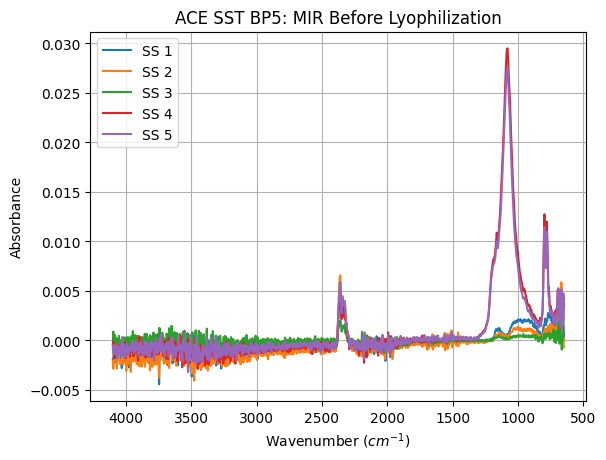

In [21]:
plot_mir_before(sample='ACE SST BP5', showAll=True)

Choosing SS 4 - higher SNR and more pronounced features than SS 5

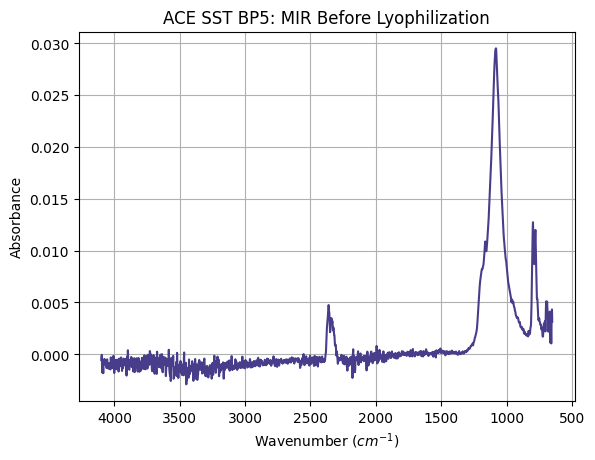

In [22]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BP5'] = 4
plot_mir_before(sample='ACE SST BP5')

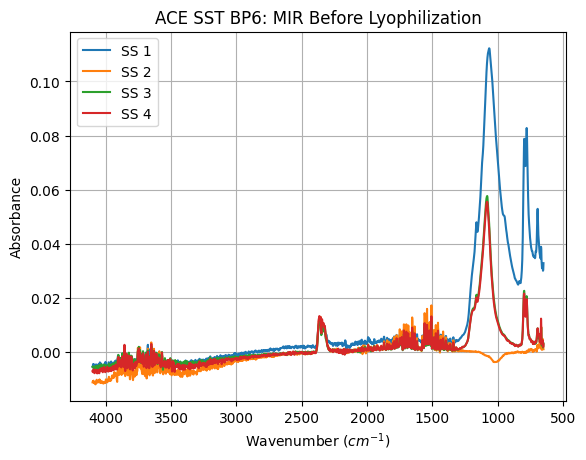

In [23]:
plot_mir_before(sample='ACE SST BP6', showAll=True)

Choosing SS 1 - higher SNR

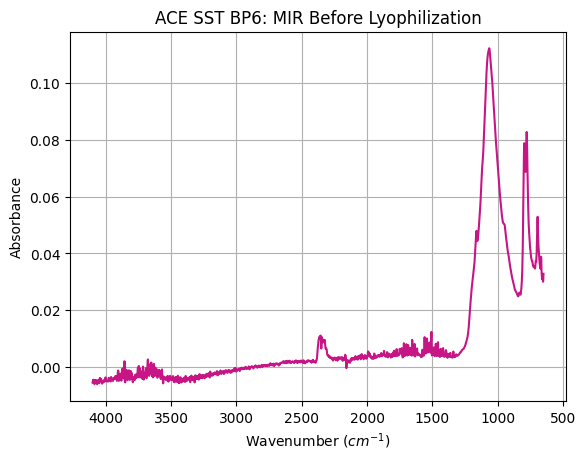

In [24]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BP6'] = 1
plot_mir_before(sample='ACE SST BP6')

The SNR is not ideal in the sandstone samples due to difficulties establishing solid contact between the sample and the sampling window.

The strong feature at $1080cm^{-1}$ is characteristic of all forms of $SiO_2$, arising from the asymmetrical stretch of the $Si-O$ bonds. The sharp feature at $1160cm^{-1}$ on the slope of the $1080cm^{-1}$ feature, the doublet at $800cm^{-1}$ and $780cm^{-1}$, and the feature at $695cm^{-1}$ (hard to decipher from the noise in ACE SST BP5) indicates that this is $\alpha$-quartz silica.

The $2350cm^{-1}$ peak is characteristic of $CO_2$, arising due to symmetric and asymmetric stretching of the $C=O$ linear bond. This structure is uncommon in other molecules, so the likely cause of this peak is carbon dioxide from the atmosphere. The background scans taken before the spectra were collected should subtract out any atmospheric effects, so the presence of these peaks may indicate issues with air circulation in the lab where the measurements were taken, which could change the levels of $CO_2$ in the air between the background and subsequent measurements. This could also explain the noise around $3400cm^{-1}$ and $1600cm^{-1}$, which could arise from $OH$ bending from $H_2O$ molecules in the atmosphere.

The small feature at $950cm^{−1}$ on the slope of the $1080cm^{-1}$ feature indicates that the silanol functional group is present, as it could arise from $Si − OH$ stretching. Previous spectroscopic analysis of sandstone from this region has revealed kaolinite and illite, both of which contain silanol, so these minerals are a likely source for this feature. The $OH$ functional group could explain the $3400cm^{-1}$ and $1600cm^{-1}$ features, although the level of noise makes these assignments tentative. It may also arise due to the $Al - OH$ bonds also present in kaolinite and illite.

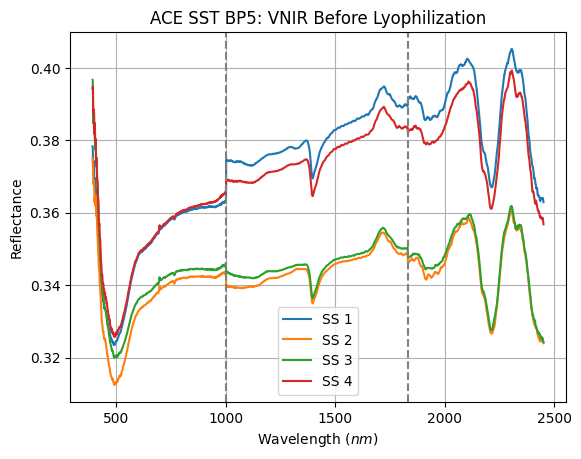

In [25]:
plot_vnir_before(sample='ACE SST BP5', showAll=True, skiprows=40)

Choosing SS 3 - smallest spectral joins

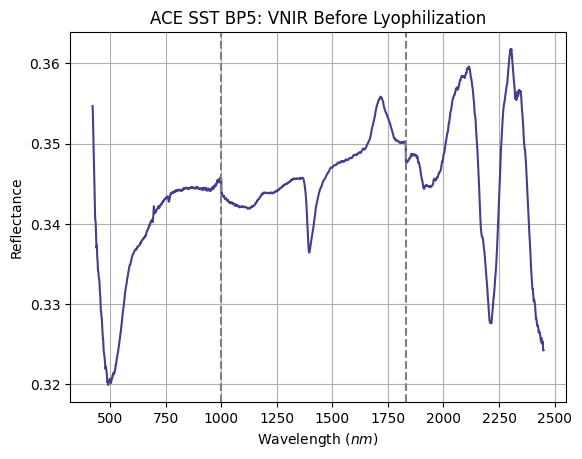

In [26]:
SELECTED_SUBSAMPLES['BEFORE_VNIR']['ACE SST BP5'] = 3
plot_vnir_before(sample='ACE SST BP5', skiprows=70)

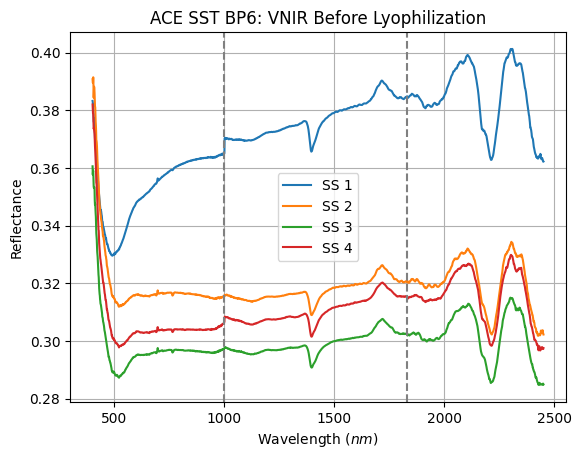

In [27]:
plot_vnir_before(sample='ACE SST BP6', showAll=True, skiprows=50)

Choosing SS 2 - smallest spectral joins

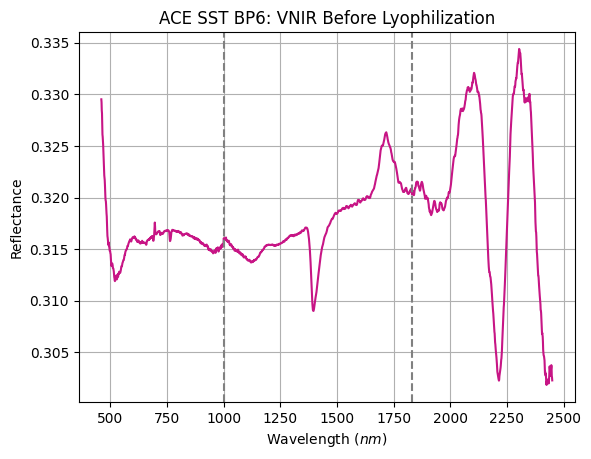

In [28]:
SELECTED_SUBSAMPLES['BEFORE_VNIR']['ACE SST BP6'] = 2
plot_vnir_before(sample='ACE SST BP6', skiprows=110)

The $2170nm$ and $2210nm$ doublet is assigned to the $Al − OH$ combination band doublet and the $1396nm$ and $1416nm$ features are assigned to the $Al − OH$ stretching overtones. The presence of this bond is indicative of kaolinite, $Al_2Si_2O_5(OH)_4$, in the sample, consistent with the $950cm^{−1}$ feature observed in MIR.

The strong absorbance band around $500nm$ and the shoulder around $630nm$ is indicative of hematite due to the charge tranfser between $O^{2-}$ and $Fe^{3+}$. Typically, hematite shows a prominent absorption around $830nm$. However, this is not visible for nanocrystalline hematite in a neutral matrix, so, if these features arise from hematite, this could be indicative of the hemtatite and mineral structure.

The broad, weak feature from $900nm$ to $1300nm$ is commonly associated with the presence of iron, such as feldspar.

The feature at $1900nm$ is most likely due to $OH$ vibrations in $H_2O$ and the feature at $2330nm$ may arise from $OH$ vibrations. Both of these compounds are found in kaolinite and illite. 

##### After Lyophilization

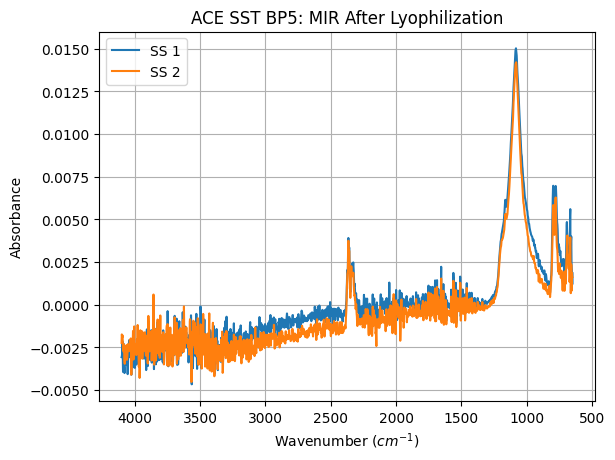

In [29]:
plot_mir_after(sample='ACE SST BP5', showAll=True)

Choosing SS 1 - slightly higher SNR

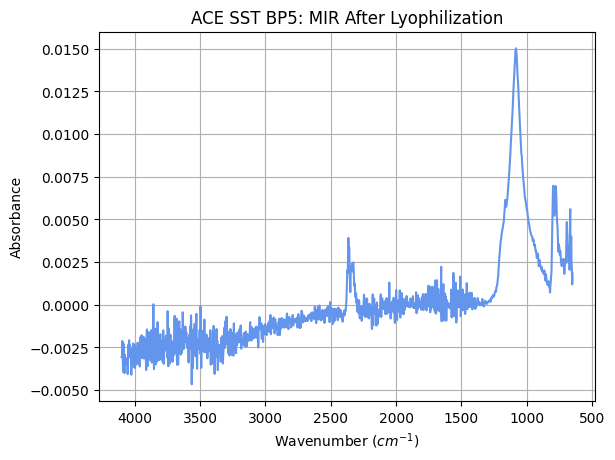

In [30]:
SELECTED_SUBSAMPLES['AFTER_MIR']['ACE SST BP5'] = 1
plot_mir_after(sample='ACE SST BP5')

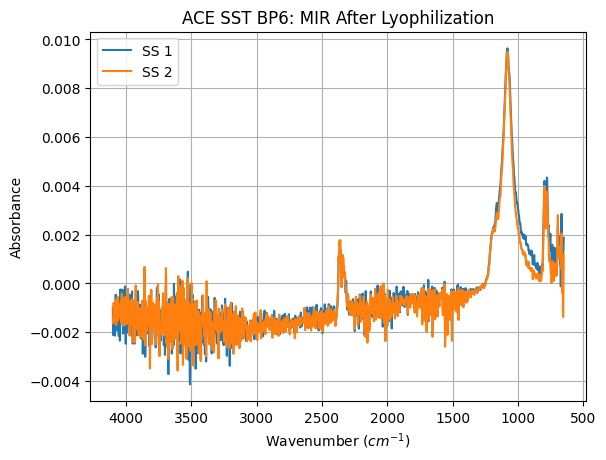

In [31]:
plot_mir_after(sample='ACE SST BP6', showAll=True)

Choosing SS 1 - possible features on the slope of the 1000 peak not seen in SS 2

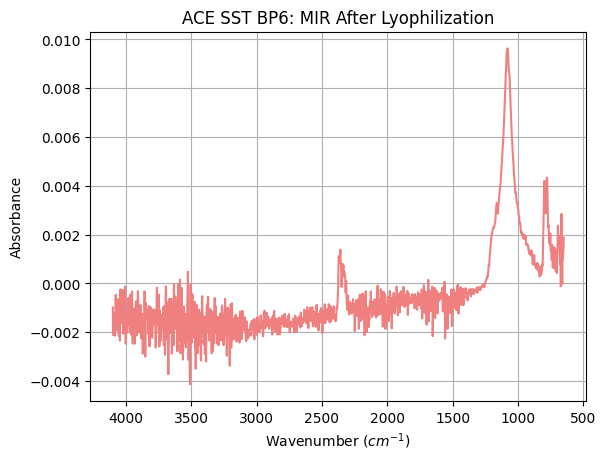

In [32]:
SELECTED_SUBSAMPLES['AFTER_MIR']['ACE SST BP6'] = 1
plot_mir_after(sample='ACE SST BP6')

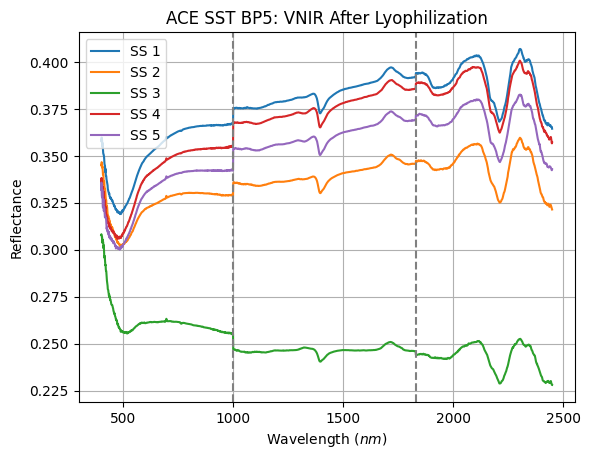

In [33]:
plot_vnir_after(sample='ACE SST BP5', showAll=True, skiprows=50)

Choosing SS 2 - smallest spectral joins

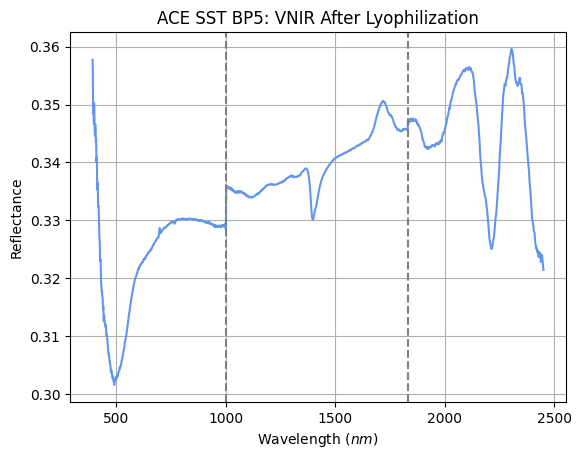

In [34]:
SELECTED_SUBSAMPLES['AFTER_VNIR']['ACE SST BP5'] = 2
plot_vnir_after(sample='ACE SST BP5', skiprows=40)

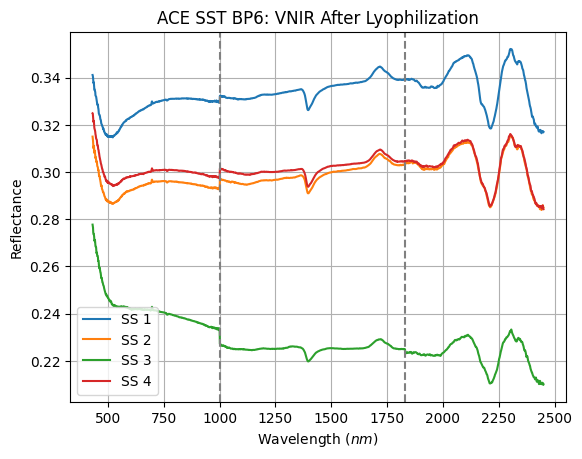

In [35]:
plot_vnir_after(sample='ACE SST BP6', showAll=True, skiprows=80)

Choosing SS 4 - smallest spectral joins and small feature around 700nm

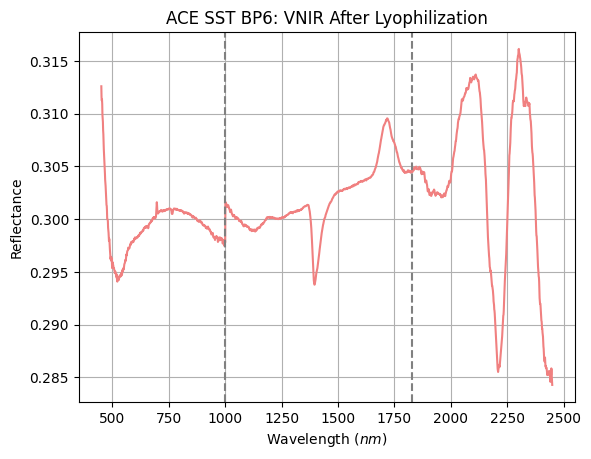

In [36]:
SELECTED_SUBSAMPLES['AFTER_VNIR']['ACE SST BP6'] = 4
plot_vnir_after(sample='ACE SST BP6', skiprows=100)

##### Lyophilization Effects

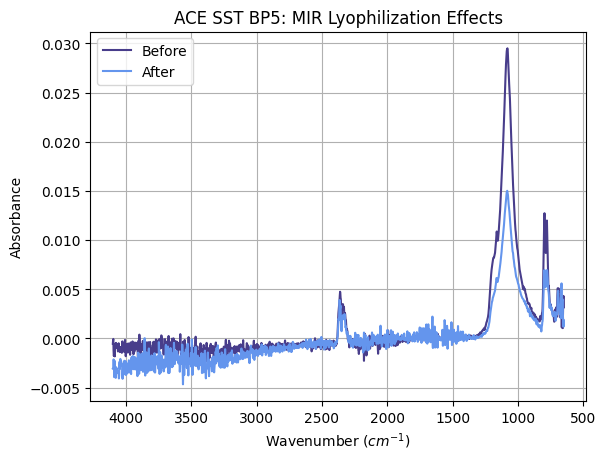

In [37]:
compare_subsamples(sample_A='ACE SST BP5', sample_A_isBefore=True, isMIR=True)

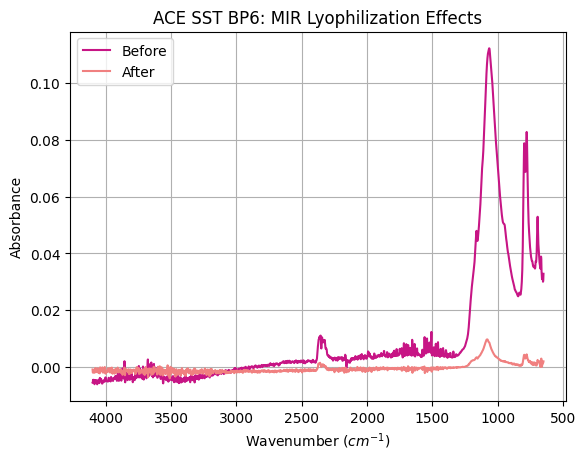

In [38]:
compare_subsamples(sample_A='ACE SST BP6', sample_A_isBefore=True, isMIR=True)

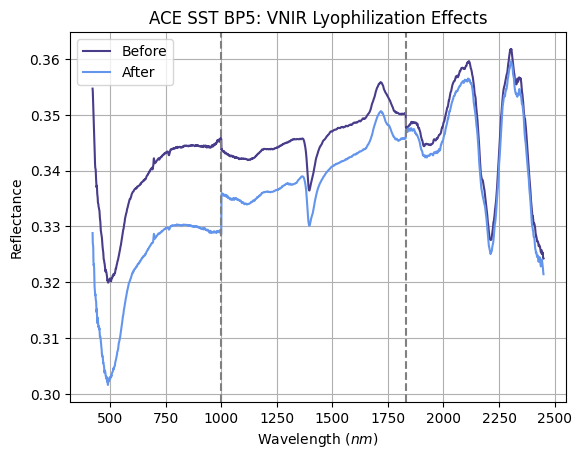

In [39]:
compare_subsamples(sample_A='ACE SST BP5', sample_A_isBefore=True, isMIR=False, skiprows_A=70)

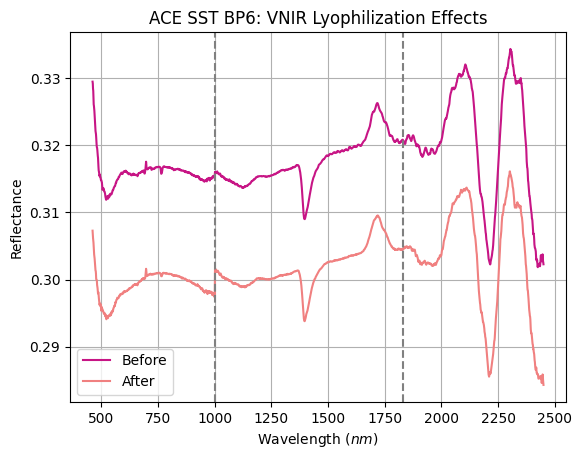

In [40]:
compare_subsamples(sample_A='ACE SST BP6', sample_A_isBefore=True, isMIR=False, skiprows_A=110)

The intensity of features generally decreases in FTIR, but this may be a result of the signal achieved rather than a direct effect of lyophilization. More data will be required to draw this conclusion more confidently. The $950cm^{-1}$ feature is significantly reduced after lyophilization. This was assigned to silanol, possibly as a part of kaolinite or illite. The hydroxyl group in these compounds is linked to source of $H_2O$: $Si - O - H - O -H$. This suggests that lyophilization may dehydrate the kaolinite, which would remove the $Si - OH$ bond. Previous work on the heating of kaolinite has shown that the water may be removed, resulting in metakaolin, $Al_2Si_2O_7$.

In VNIR, there are no notable differences between the spectra, even in the $1900nm$ peak attributed to water. This could suggest that the silanol group was removed, but the water may still be present within the sample and was not fully sublimated.

#### ACE SST BLACK

##### Before Lyophilization

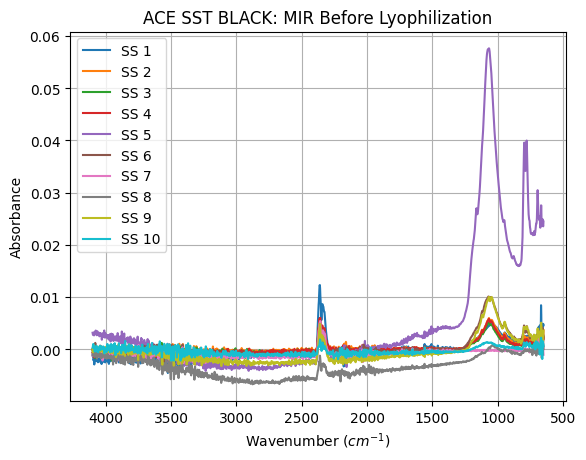

In [41]:
plot_mir_before(sample='ACE SST BLACK', showAll=True)

Choosing SS 5 - higher SNR

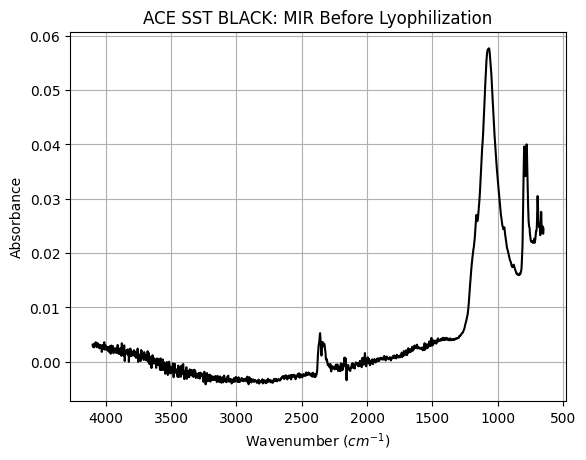

In [42]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['ACE SST BLACK'] = 5
plot_mir_before(sample='ACE SST BLACK')

This sample shows largely the same features as the crustal layer, indicating the presence of silica and possibly phyllosilicates, such as kaolinite or illite.

One new feature observed in the BLACK sample is the feature at $880cm^{-1}$

The two features around $1400cm^{-1}$ and $1620cm^{-1}$ are consitent with $OH$ vibrations observed in kaolinite and illite, which could have been more prevalent on the sampling window when this spectrum was collected, as the features were not consistently seen in all spectra for the BLACK sample. The $1620cm^{-1}$ may also arise from $OH$ vibrations in water.

These two features either side of $1500cm^{-1}$ resemble those that arise from $C = O$ and $C − O$ stretching at $1318cm^{-1}$ and $1618cm^{-1}$ respectively. These could arise from oxalic acid, produced by fungi as a by-product. The $C = O$ peak does not align with the typical oxalic acid feature, but hydrated calcium oxalates (whewellite and weddellite) have been detected in similar samples, so further work could be done to investigate the presence of calcium oxalates in this sample and the effects of the mineralogy on the positions of the features. This explanation could explain why the features are present in the BLACK layer but not the crustal layer. It may also offer an explanation for the feature around $880cm^{-1}$, as weddellite has a characteristic feature at $910cm^{−1}$, which is the hydrated version of calcium oxalate we would expect to observe in the BLACK layer.

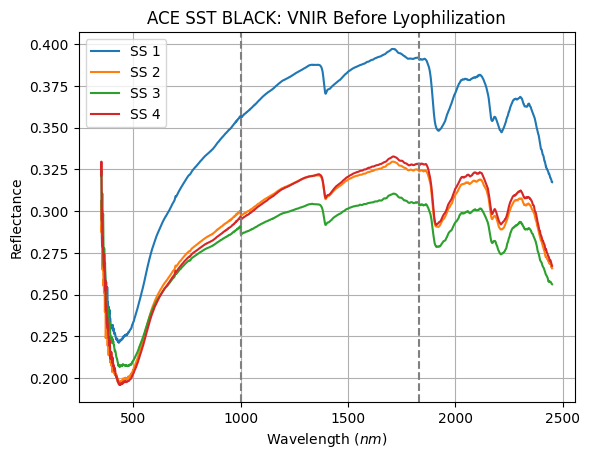

In [43]:
plot_vnir_before(sample='ACE SST BLACK', showAll=True)

Choosing SS 4 - smallest spectral joins and reflectance more similar to other subsamples compared to SS 1

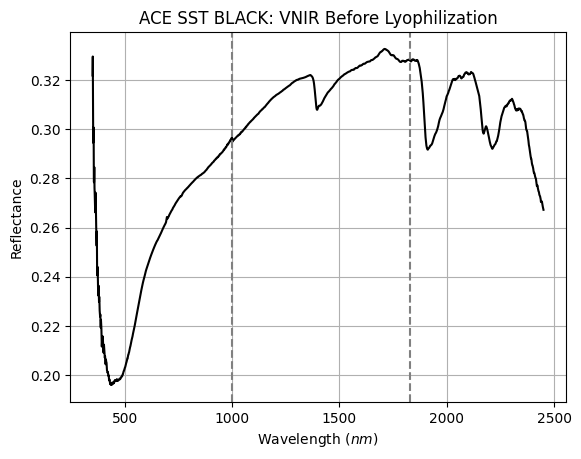

In [44]:
SELECTED_SUBSAMPLES['BEFORE_VNIR']['ACE SST BLACK'] = 4
plot_vnir_before(sample='ACE SST BLACK')

There is a much lower reflectance over the visible range in the BLACK layer than in the crustal layer. This may be due to this sample being darker, meaning that it absorbs more light in the visible range. Unlike in the crustal spectra, there is no shoulder around $630nm$ and no weak, broad feature around $1100nm$ to $1300nm$, suggesting that there is no iron in this sample. This can be explained by iron leaching, as the lichen mobilize iron compounds, depleting them from the inhabited zone and depositing them at the layers above and below. 

The $1900nm$ feature is more intense than in the crustal layer, which indicates larger quantities of water. This could be explained by the presence of hydrated calcium oxalates, which there is some evidence for in the FTIR spectrum. Another potential source of water in this sample could be from halloysite, a hydrated form of kaolinite with a tubular morphology and water molecules between layers. Halloysite forms due to hydrothermal alteration of alumino-silicate minerals, but I need to do more research to investigate whether this process would occur preferentially in the BLACK layer over the crustal layer. $H_2O$ external to the halloysite tubes is needed to maintain hydration in the interlayer, and my initial thoughts are that the water would not be available during the winter months. XRD or TEM would provide valuable follow ups, as these techniques can distinguish the structure (basal spacing) of kaolinite and halloysite. The water layer is lost easily, but remains unfrozen down to $-75C$, which makes the effects of lyophlization interesting as we will not be reducing the temperature below this temperature. Halloysite has been observed in McMurdo due to volcanic ash, which could explain its presence but does not explain why we would observe more of it in the BLACK layer.

##### After Lyophilization

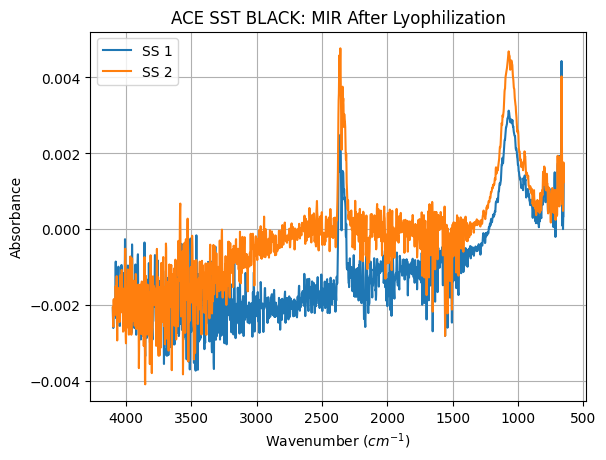

In [45]:
plot_mir_after(sample='ACE SST BLACK', showAll=True)

Choosing SS 2 - higher SNR and baseline lies closer to 0

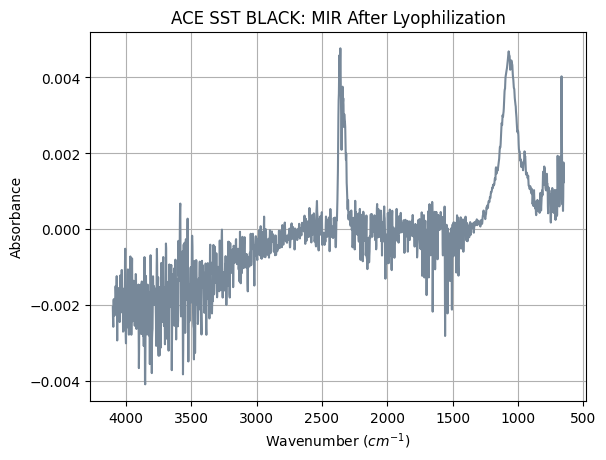

In [46]:
SELECTED_SUBSAMPLES['AFTER_MIR']['ACE SST BLACK'] = 2
plot_mir_after(sample='ACE SST BLACK')

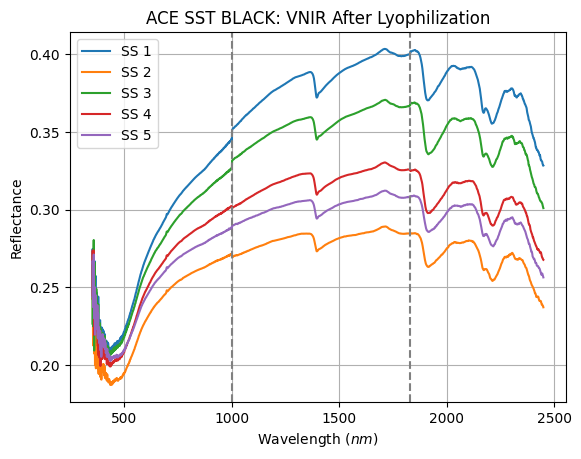

In [47]:
plot_vnir_after(sample='ACE SST BLACK', showAll=True)

Choosing SS 4 - smallest spectral joins

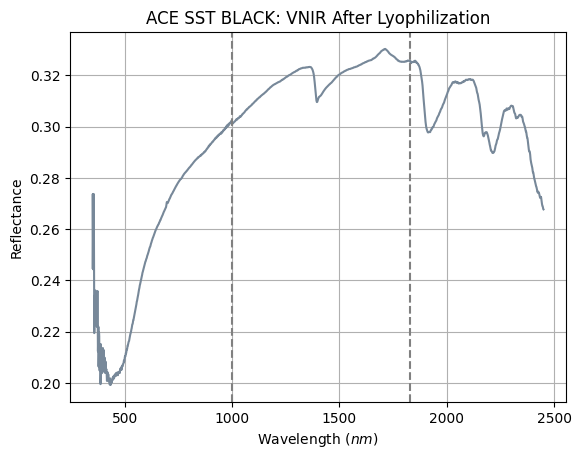

In [48]:
SELECTED_SUBSAMPLES['AFTER_VNIR']['ACE SST BLACK'] = 4
plot_vnir_after(sample='ACE SST BLACK')

##### Lyophilization Effects

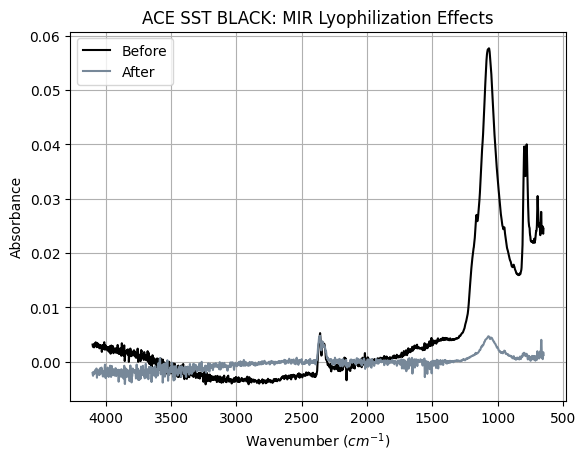

In [49]:
compare_subsamples(sample_A='ACE SST BLACK', sample_A_isBefore=True, isMIR=True)

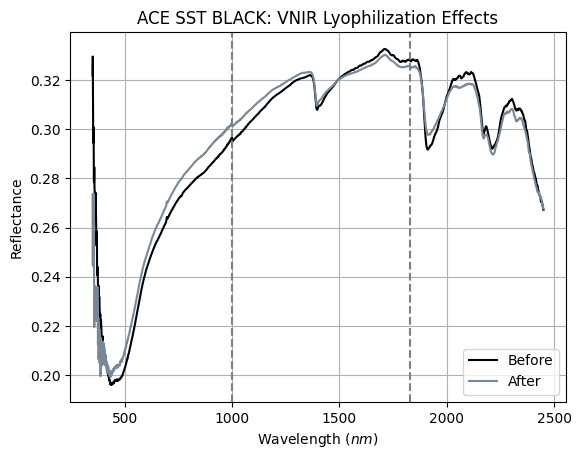

In [50]:
compare_subsamples(sample_A='ACE SST BLACK', sample_A_isBefore=True, isMIR=False)

As with the crustal layer, there is a general decrease in intensity in the FTIR spectra. Unlike in the crustal layer, there is very little change between the spectra before and after lyophilization. The features around $1500cm^{-1}$ are not present after lyophilization, but this could be attributed to the lower signal, as the features were also not prevalent in all spectra collected before lyophilization. There is still some indication of the $950cm^{-1}$ feature in this sample. This could suggest some differences between the source of the potential silanol group, or that the lyophilization process affects this bond differently based on differences in the mineralogy of the samples. More data and improvements in the signal would allow for more confident analysis of this. Another difference is that the BLACK layer shows a decrease in intensity of the $1900nm$ feature in VNIR. This suggests that water is lost from the BLACK layer during lyophilization, which adds some support that the effects and/or mineralogy are different between the BLACK and crustal layers.

#### ACE SST Comparisons

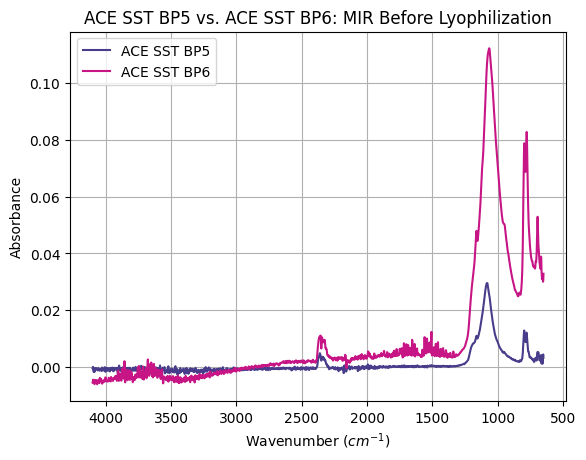

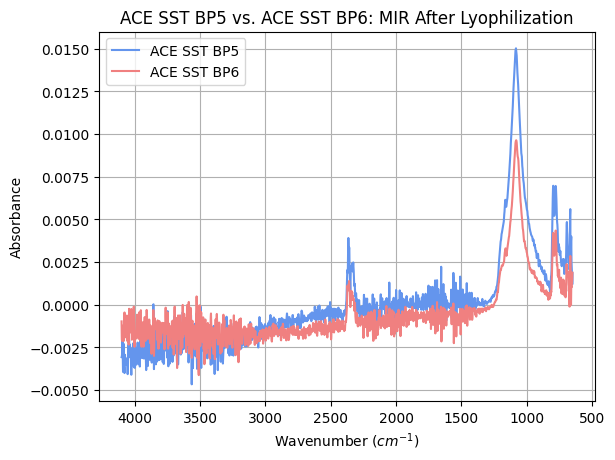

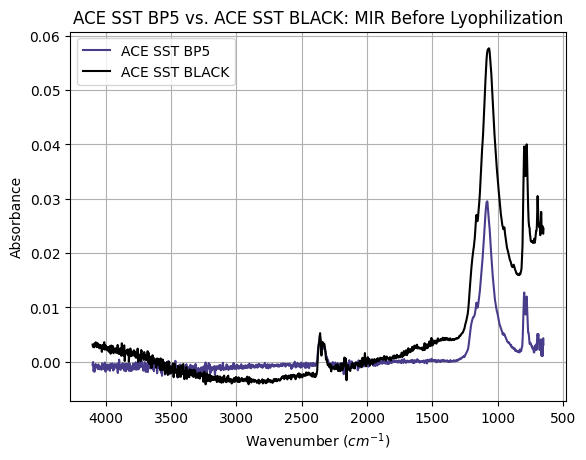

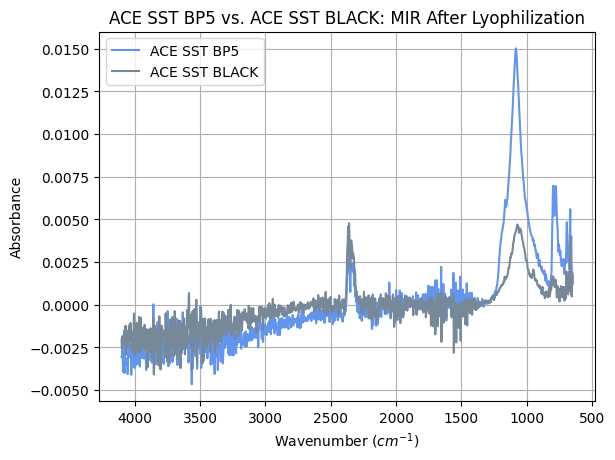

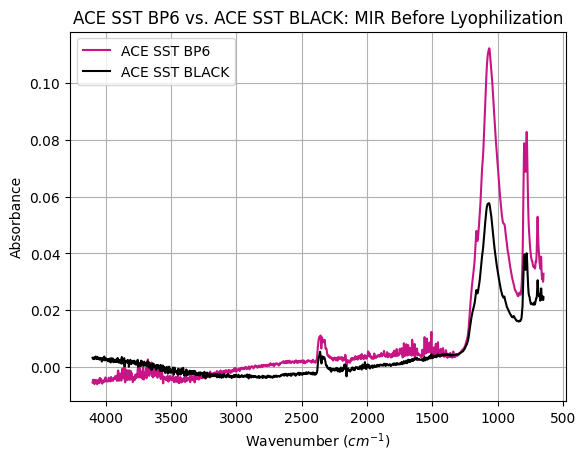

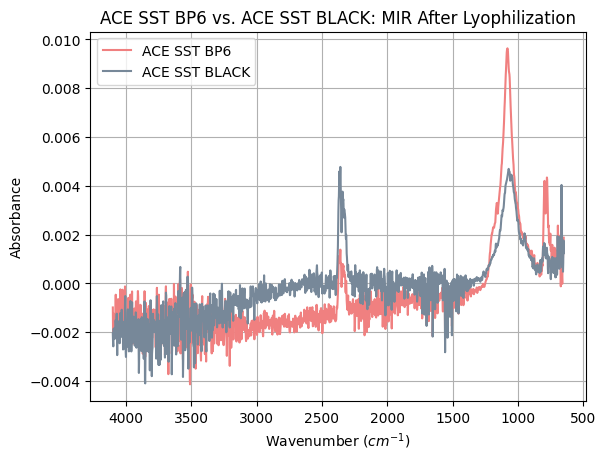

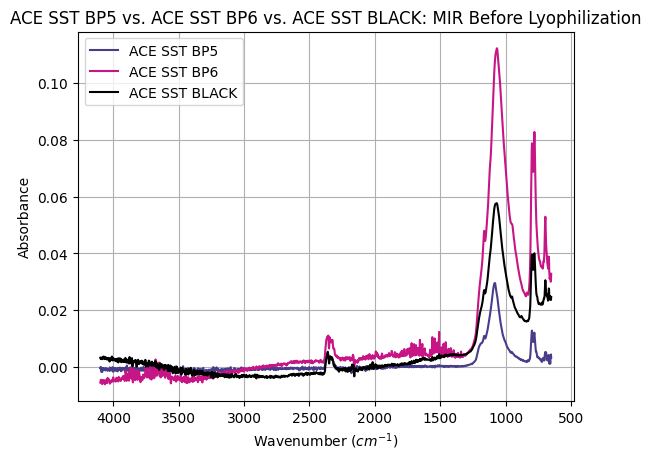

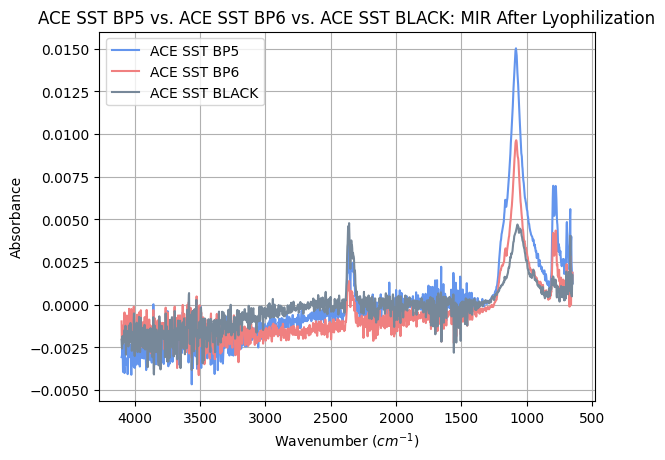

In [51]:
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_C='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, sample_C_isBefore=True, isMIR=True)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_C='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, sample_C_isBefore=False, isMIR=True)

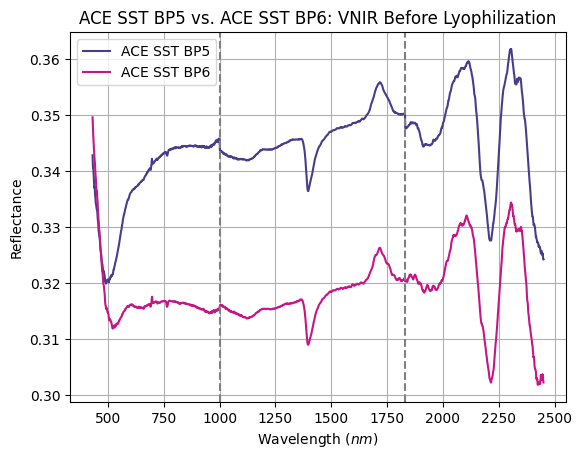

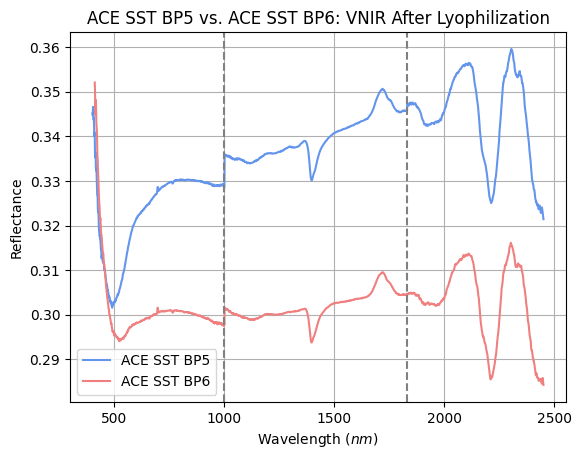

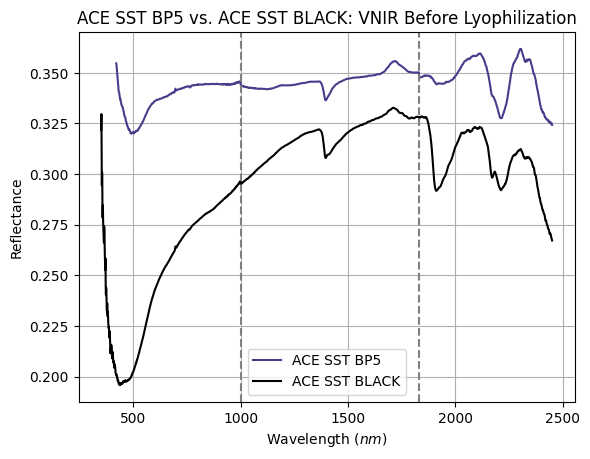

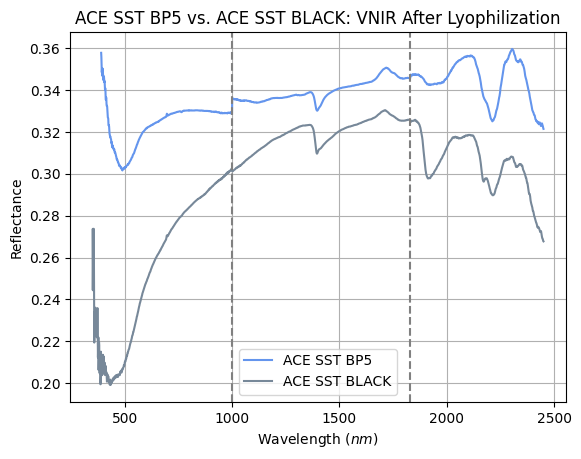

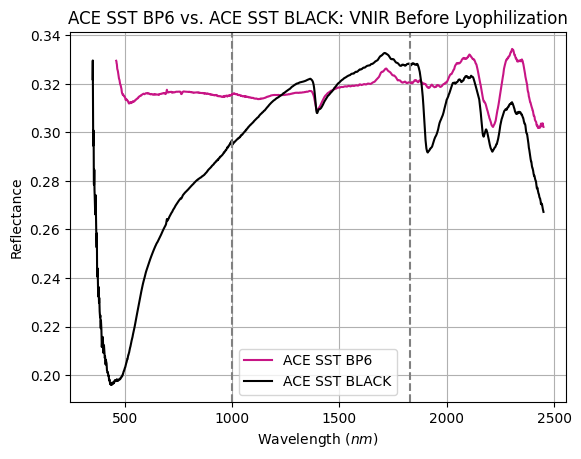

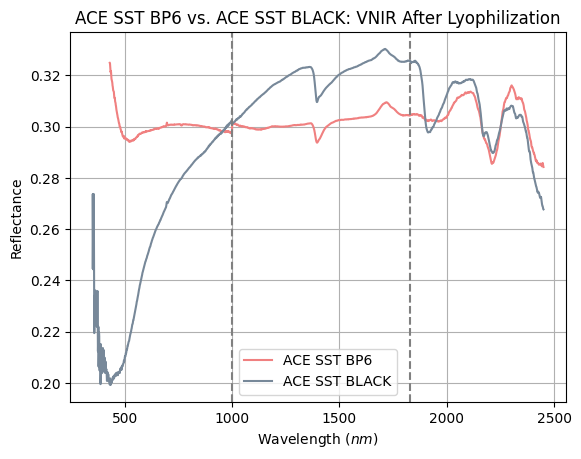

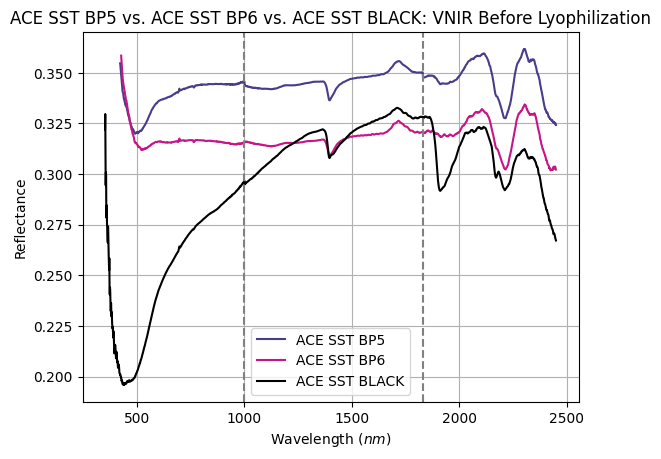

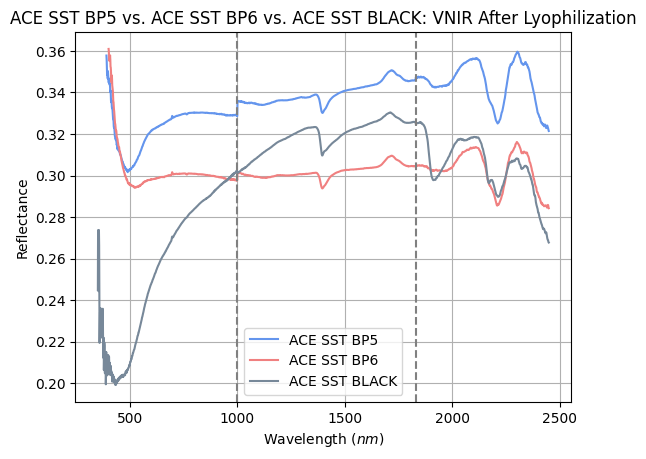

In [52]:
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False, skiprows_A=80, skiprows_B=80)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False, skiprows_A=50, skiprows_B=60)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False, skiprows_A=70)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False, skiprows_A=40)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False, skiprows_A=110)
compare_subsamples(sample_A='ACE SST BP6', sample_B='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False, skiprows_A=80)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_C='ACE SST BLACK', sample_A_isBefore=True, sample_B_isBefore=True, sample_C_isBefore=True, isMIR=False, skiprows_A=70, skiprows_B=75)
compare_subsamples(sample_A='ACE SST BP5', sample_B='ACE SST BP6', sample_C='ACE SST BLACK', sample_A_isBefore=False, sample_B_isBefore=False, sample_C_isBefore=False, isMIR=False, skiprows_A=40, skiprows_B=50)

### Martian Regloith Simulant

#### SOPHIA

##### Before Lyophilization

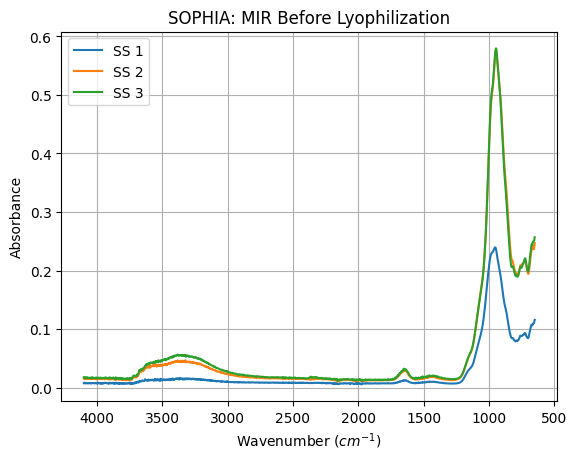

In [53]:
plot_mir_before(sample='SOPHIA', showAll=True)

Choosing SS 3 - higher SNR

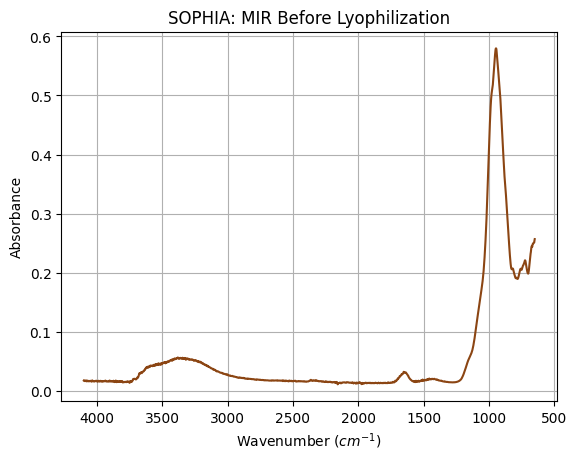

In [54]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['SOPHIA'] = 3
plot_mir_before(sample='SOPHIA')

* $3400cm^{-1}$ - $O-H$ stretching from vermiculite.
* $1650cm^{-1}$ - $O-H$ stretching in <a href="https://www.researchgate.net/publication/262915474_Similarities_in_chemical_composition_of_soil_organic_matter_across_a_millennia-old_paddy_soil_chronosequence_as_revealed_by_advanced_solid-state_NMR_spectroscopy">phylosilicates</a>, $C=O$ stretching in siderite.
* $1460cm^{-1}$ - $O-H$ bending from phylosilicates, $Ca-O$ in plagioclase and augite.
* $950cm^{-1}$ - silicates. $Mg-O$ overtones from vermiculite and olivine. $Al-OH$ from phylosilicates.
* $800cm^{-1}$ - small broad peak from <a href="https://www.gelest.com/wp-content/uploads/5000A_Section1_InfraredAnalysis.pdf">amorphous silica</a>.
* $725cm^{-1}$ - $Mg-O$, $Fe-O$.
* $650cm^{-1}$ - $Fe-O$ stretch.

These assignments are based on the <a href="https://oro.open.ac.uk/88399/1/1-s2.0-S0019103523001458-main.pdf">SOPHIA mineralogy</a>:
* Phylosilicates ($40\%$)
    * Vermiculite ($26\%$): $(Mg, Fe^{2+}, Fe^{3+})_3[(Al, Si)_4O_{10}](OH)_24H_2O$.
    * Serpentine ($3\%$): $(Mg^{2+}, Fe^{2+}, Ni^{2+}, Mn^{2+}, Zn^{2+})_3Si_2O_5(OH)_4$.
    * Biotite ($2\%$): $K(Mg, Fe)_3(AlSi_3O_{10})(F, OH)_2$.
* Anhydrous minerals ($45\%$)
    * Plagioclase ($22\%$): $NaAlSi_3O_8 - CaAl_2Si_2O_8$.
    * Orthoclase ($3\%$): $KAlSi_3O_8$.
    * Pyroxene (Augite) ($15\%$): $(Ca, Na)(Mg, Fe, Al, Ti)(Si, Al)_2O_6$.
    * Olivine ($5\%$): $(Mg, Fe)_2SiO_4$.
* Anhydrous component ($11\%$)
    * Amorphous FeOOH ($1\%$)
    * Iron silicate ($10\%$): $Fe_2SiO_4$.
* Haematite ($1\%$): $Fe_2O_3$.
* Siderite ($2\%$): $FeCO_3$.

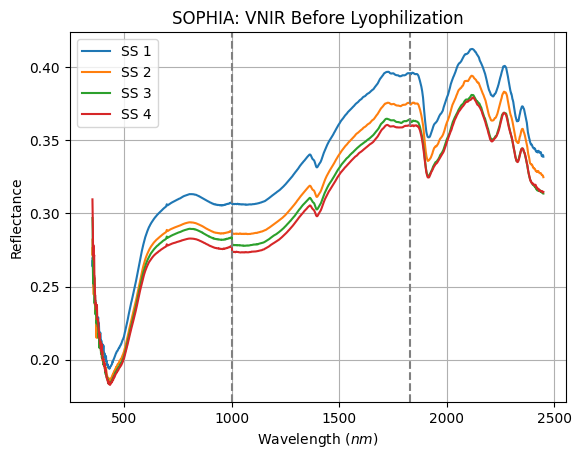

In [55]:
plot_vnir_before(sample='SOPHIA', showAll=True)

Choosing SS 1 - smallest spectral joins

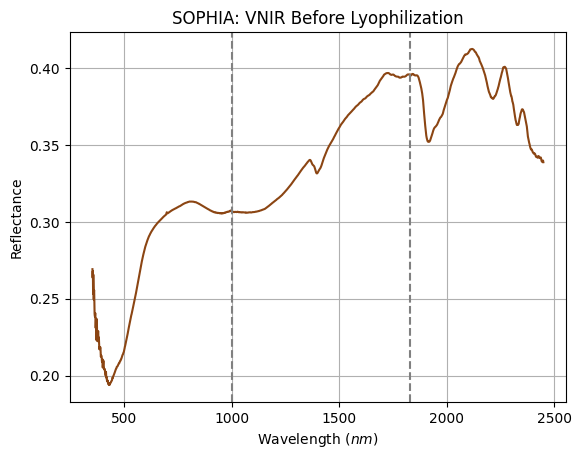

In [56]:
SELECTED_SUBSAMPLES['BEFORE_VNIR']['SOPHIA'] = 1
plot_vnir_before(sample='SOPHIA')

The strong absorbance band around $430nm$ and the shoulder around $630nm$ arises due to the charge tranfser between $O^{2-}$ and $Fe^{3+}$. The $430$ absorption is indicative of $Fe^{3+}$ in tetrahedral coordination. This could arise from many of the iron-bearing minerals in SOPHIA. The broad band from $800nm$ - $1300nm$ is characteristic of olivine, arising due to the iron-content in this particular mineralogy making the iron feature much broader than in other minerals.

The $2210nm$ feature is likely due to $OH$ vibrations, shifted from $2200nm$ to $2210nm$ due to the presence of $Fe$ or $Mg$ in the octahedral site.

The $1396nm$, $1900nm$, and $2300nm$ features arise due to $OH$ vibrations. The $1900nm$ and $2300nm$ features are likeyl associated with hydration, but the $1396nm$ feature is more likely to arise from hydroxyl groups in the phylosilicates.

##### After Lyophilization

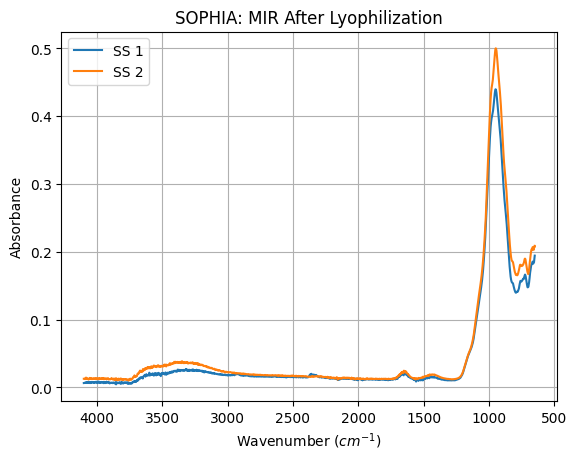

In [57]:
plot_mir_after(sample='SOPHIA', showAll=True)

Choosing SS 2 - higher SNR

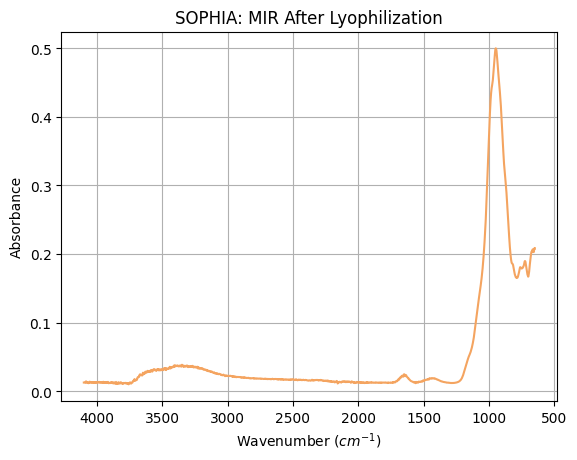

In [58]:
SELECTED_SUBSAMPLES['AFTER_MIR']['SOPHIA'] = 2
plot_mir_after(sample='SOPHIA')

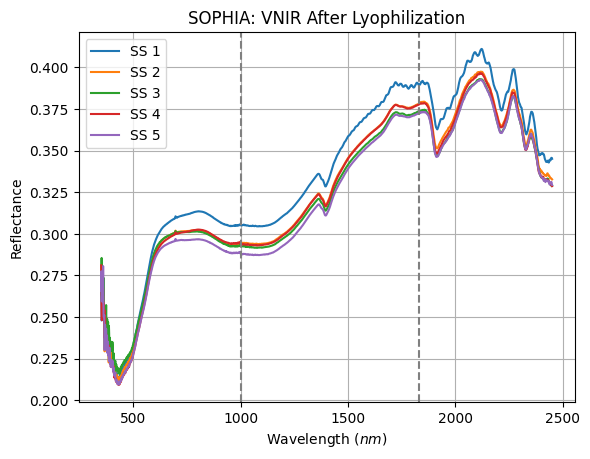

In [59]:
plot_vnir_after(sample='SOPHIA', showAll=True)

Choosing SS 1 - features are more prominent

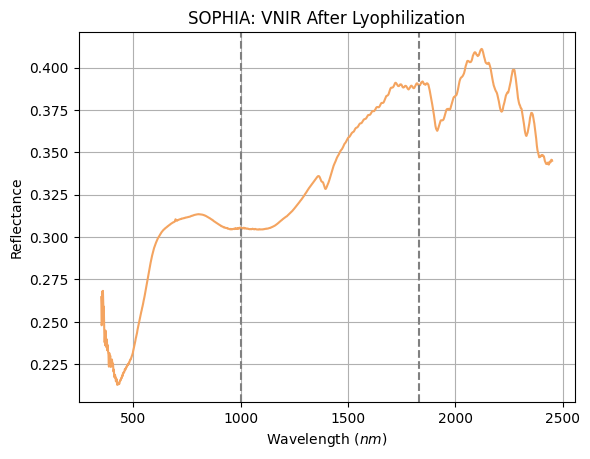

In [60]:
SELECTED_SUBSAMPLES['AFTER_VNIR']['SOPHIA'] = 1
plot_vnir_after(sample='SOPHIA')

##### Lyophilization Effects

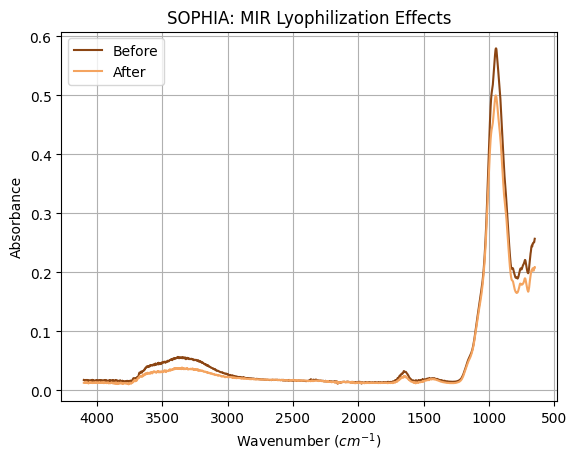

In [61]:
compare_subsamples(sample_A='SOPHIA', sample_A_isBefore=True, isMIR=True)

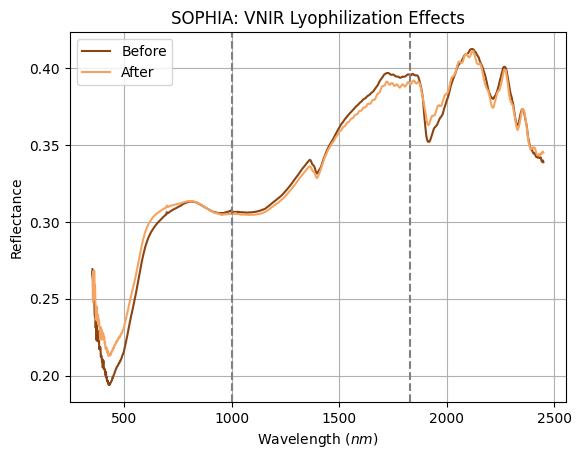

In [62]:
compare_subsamples(sample_A='SOPHIA', sample_A_isBefore=True, isMIR=False)

The spectra are very similar for this sample. There is a slight general decrease in peak intensity after lyophilization in FTIR, but the same features are present before and after lyophilization. In VNIR, the spectra also look similar with noticeable decreases around the $400nm$ and $1900nm$ features. This is consistent with the $1900nm$ feature being associated with water, but more work is needed to understand what may cause the decreased intensity with the feature assigned to iron-bearing minerals.  

#### SCOTT MAT

##### Before Lyophilization

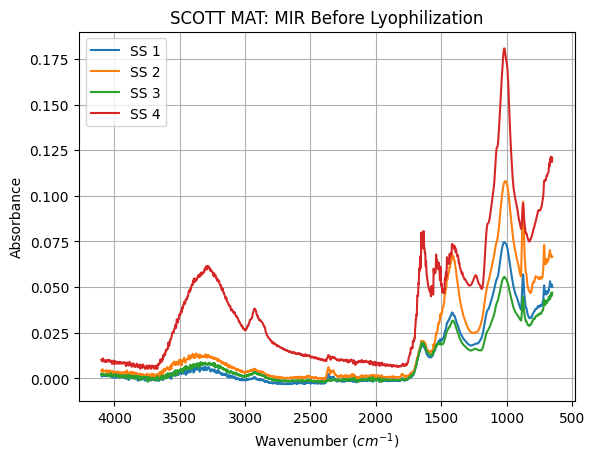

In [63]:
plot_mir_before(sample='SCOTT MAT', showAll=True)

Choosing SS 1 - more pronounced features, particularly at lower wavenumbers, but SS 4 displays a much stronger peak around $1500cm^{-1}$.

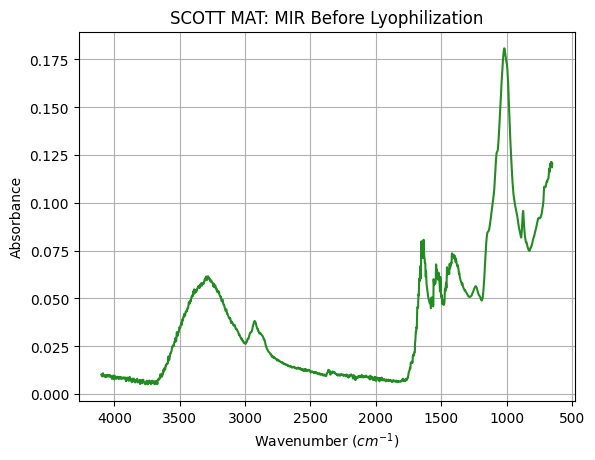

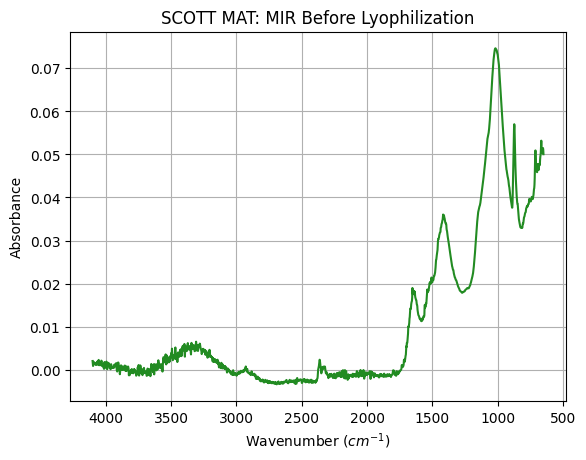

In [64]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['SCOTT MAT'] = 4
plot_mir_before(sample='SCOTT MAT')

SELECTED_SUBSAMPLES['BEFORE_MIR']['SCOTT MAT'] = 1
plot_mir_before(sample='SCOTT MAT')

* $3000cm^{-1}$ - $3700cm^{-1}$: $O-H$ (water in cytoplasm, chlorophyll) and $N-H$ (proteins) stretching
* $2880cm^{-1}$ and $2925cm^{-1}$ doublet: $CH_2$ symmetric and asymmetric stretch (lipids, chlorophyll)
* $2350cm^{-1}$: $CO_2$ doublet
* $1653cm^{-1}$: amide I band $C=O$ stretch (proteins, $\beta$-pleated protein sheet structure, aldehyde in chlorophyll)
* $1540cm^{-1}$: amide II band $N-H$ bend and $C-N$ stretch (proteins)
* $1420cm^{-1}$: $CH_2$ and $CH_3$ bend at $1450cm^{-1}$ (polysaccharides, chlorophyll) or $O-H$ bending at $1410cm^{-1}$ (polysaccharides)
* $1235cm^{-1}$: $P=O$ asymmetric stretch (DNA)
* $1150cm^{-1}$: small, $C-O$ (cellulose)
* $1018cm^{-1}$: $C-O$ symmetric stretch (polysaccharides, chlorophyll)
* $874cm^{-1}$: $C-O$ stretch (polysaccharides, chlorophyll)
* $712cm^{-1}$: $CH_2$ rocking (lipids, chlorophyll)

Microbial mats typically consist of cyanobacteria in the upper layers and sulfate-reducing bacteria in the lower layers. The green appearance of the mat is due to chlorophyll-a, used by cyanobacteria to convert sunlight into chemical energy. The mats are held together and bound to their substrates by extracellular polymeric substance (EPS), which consist mostly of polysaccharides and proteins, but also include lipids and nucleic acids. The <a href="https://www.geeksforgeeks.org/cyanobacteria-structure-examples/">structure of cyanobacteria cells</a> is well-studied, so we can draw upon this to make more detailed inferences about where peaks arise in the spectra. Components in the cells are largely comprised of lipids, proteins, polysaccharides, and DNA, which explains many of the features present in the spectra.

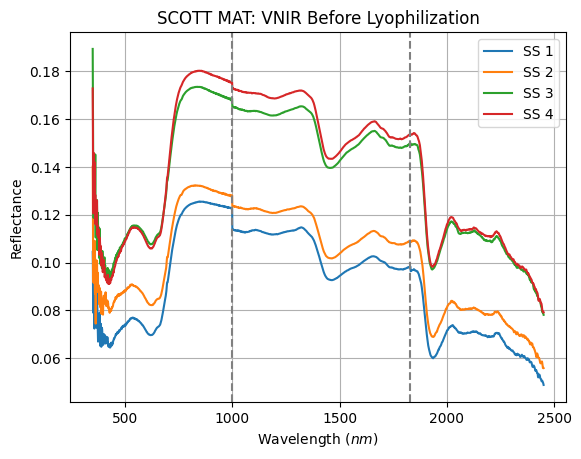

In [65]:
plot_vnir_before(sample='SCOTT MAT', showAll=True)

Choosing SS 4 - smallest spectral joins

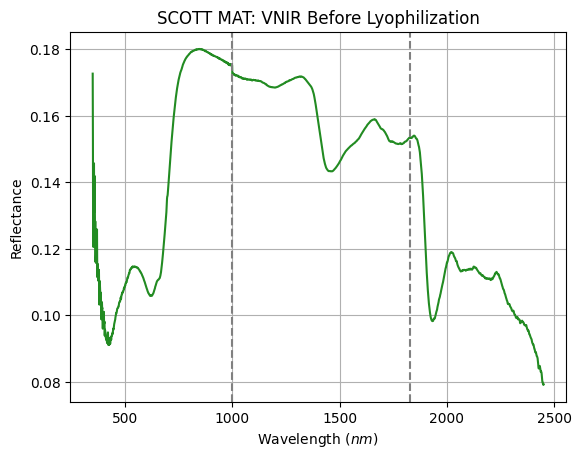

In [66]:
SELECTED_SUBSAMPLES['BEFORE_VNIR']['SCOTT MAT'] = 4
plot_vnir_before(sample='SCOTT MAT')

In the visible region, there is an increased reflectance between $420nm$ and $620nm$, which is coincides with the green region of the visible spectrum, consistent with presence of cholorphyll. The main feature at $620nm$ is assigned to chlorophyll-a and the much smaller feature at $660nm$ is assigned to chlorophyll-b.

The $2050nm$ and $2180nm$ features are assigned to proteins.

The $1400nm$, $1700nm$, and $1900nm$ are assigned to $OH$ vibrations.

##### After Lyophilization

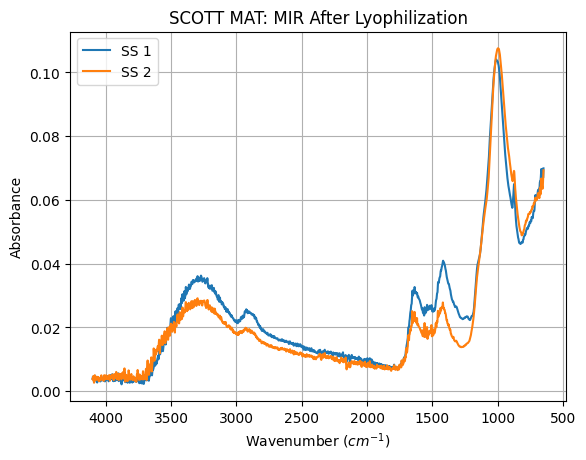

In [67]:
plot_mir_after(sample='SCOTT MAT', showAll=True)

Choosing SS 1 - higher SNR

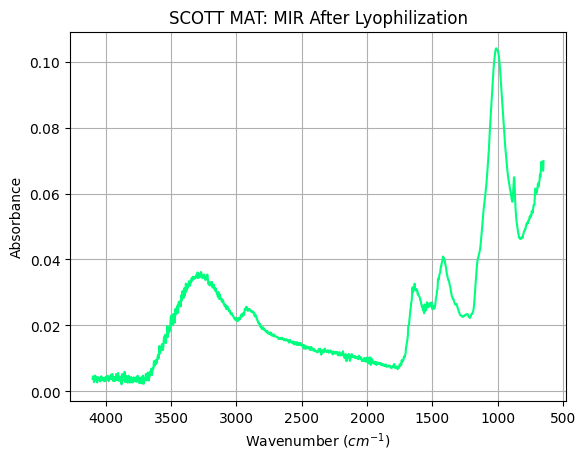

In [68]:
SELECTED_SUBSAMPLES['AFTER_MIR']['SCOTT MAT'] = 1
plot_mir_after(sample='SCOTT MAT')

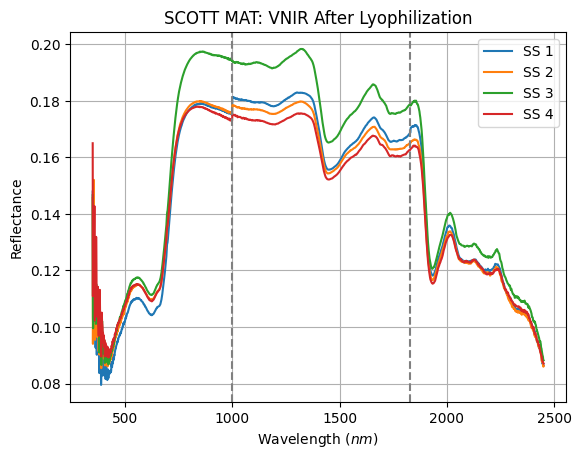

In [69]:
plot_vnir_after(sample='SCOTT MAT', showAll=True)

Choosing SS 3 - smallest spectral joins

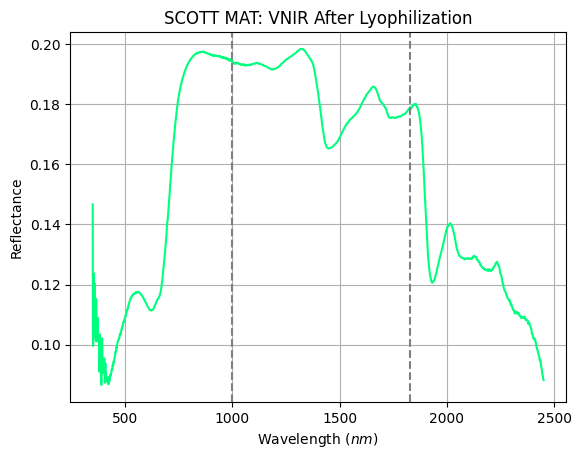

In [70]:
SELECTED_SUBSAMPLES['AFTER_VNIR']['SCOTT MAT'] = 3
plot_vnir_after(sample='SCOTT MAT')

##### Lyophilization Effects

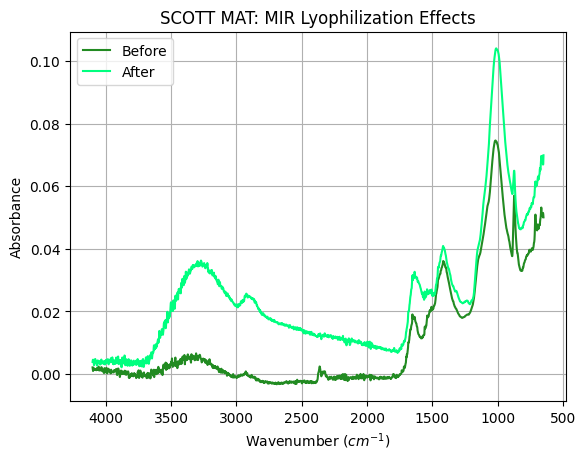

In [71]:
compare_subsamples(sample_A='SCOTT MAT', sample_A_isBefore=True, isMIR=True)

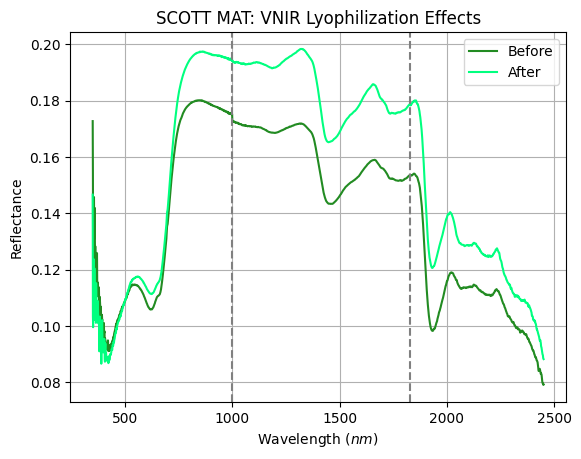

In [72]:
compare_subsamples(sample_A='SCOTT MAT', sample_A_isBefore=True, isMIR=False)

For this sample, the FTIR showed a larger signal after the lyophilization process and a lot of the features were still present. However, at the lower wavenumbers the peaks show a significant decrease, such as the $712cm^{-1}$ peak assigned to $CH_2$ rocking.

We still see strong $O-H$ features after lyophilization, which suggests that a lot of the $O-H$ bonds are functional groups attached to compounds within the sample, rather than coming from free water that would have sublimated during the lyophilization process.

The $874cm^{-1}$ and $712cm^{-1}$ features in FTIR decrease in intensity, but all features are still well defined in both spectra after lyophilization.

#### SOPHIA MAT

##### Before Lyophilization

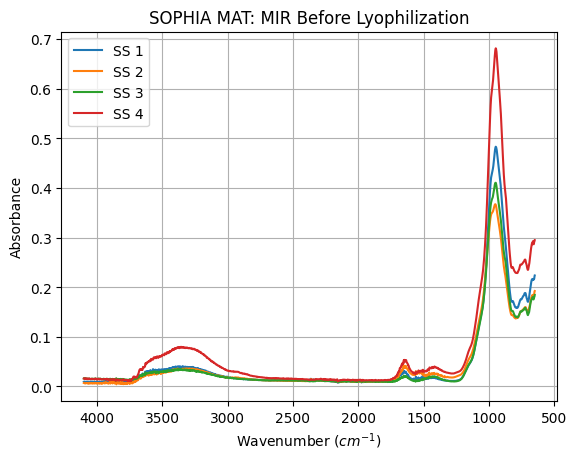

In [73]:
plot_mir_before(sample='SOPHIA MAT', showAll=True)

Choosing SS 4 - higher SNR

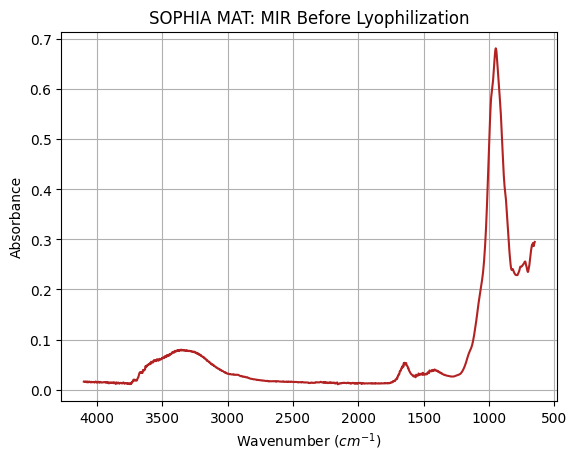

In [74]:
SELECTED_SUBSAMPLES['BEFORE_MIR']['SOPHIA MAT'] = 4
plot_mir_before(sample='SOPHIA MAT')

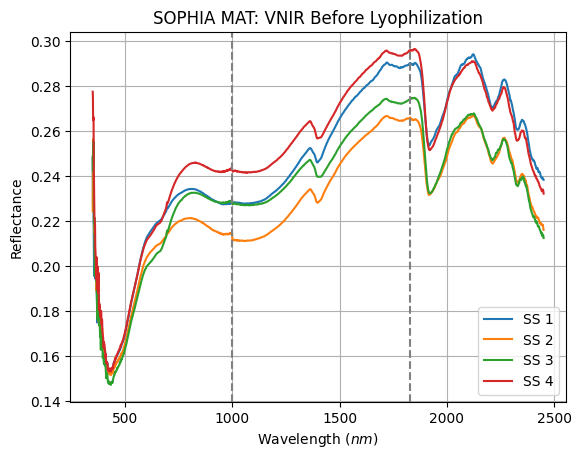

In [75]:
plot_vnir_before(sample='SOPHIA MAT', showAll=True)

Choosing SS 3 - smallest spectral joins

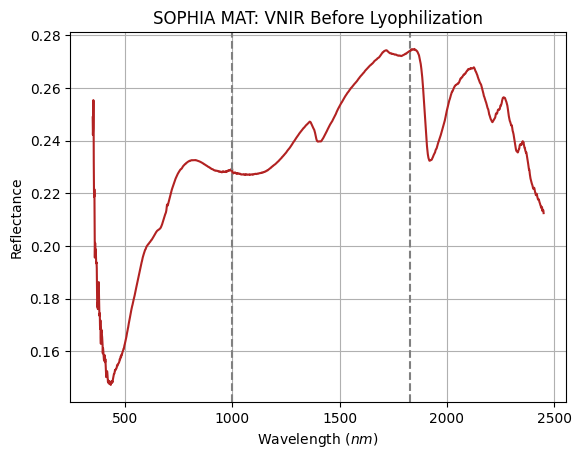

In [76]:
SELECTED_SUBSAMPLES['BEFORE_VNIR']['SOPHIA MAT'] = 3
plot_vnir_before(sample='SOPHIA MAT')

This looks very similar to the spectra of SOPHIA without the mat, which means that the simluant masks a lot of the organic features present in the mat. However, two notable expections in FTIR are the small peak around $1530cm^{-1}$, which we assigned to Amide II vibrational modes of proteins, and a very small peak around $2900cm^{-1}$, which we assigned to stretching in $CH_2$. The $1530cm^{-1}$ peak did not show up in all subsamples for SCOTT MAT and only showed a strong presence in one subsample, so that should be considered when analysing the lyophilization effects. In VNIR, the $620m$ feature assiged to chlorophyll-a persists, which may be valuable when searching for features that do not get masked by minerals.

##### After Lyophilization

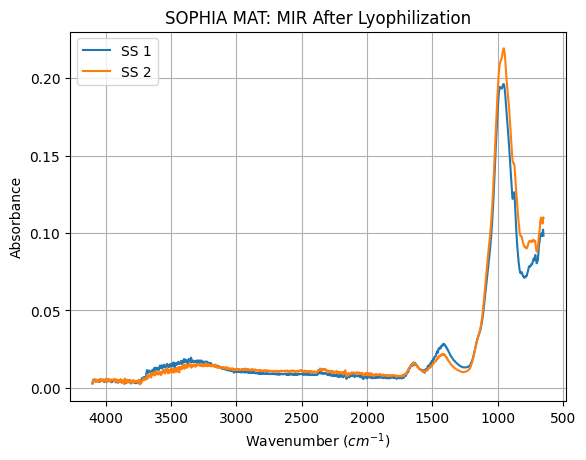

In [77]:
plot_mir_after(sample='SOPHIA MAT', showAll=True)

Choosing SS 1 - small feature on the slope of the 1000 peak that isn't visible in SS 2. SS 2 has better signal for the peaks at lower wavelengths, but these are still present in SS 1

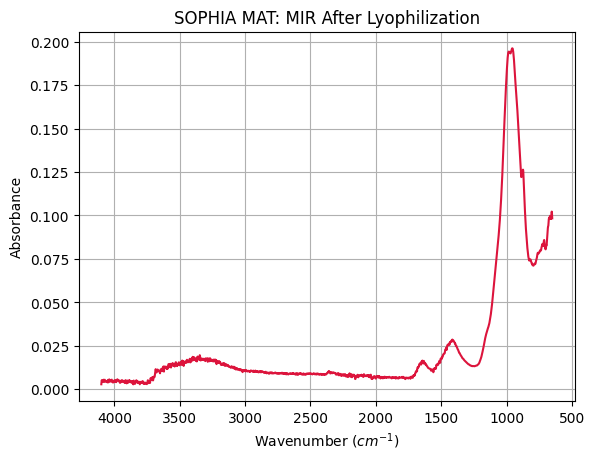

In [78]:
SELECTED_SUBSAMPLES['AFTER_MIR']['SOPHIA MAT'] = 1
plot_mir_after(sample='SOPHIA MAT')

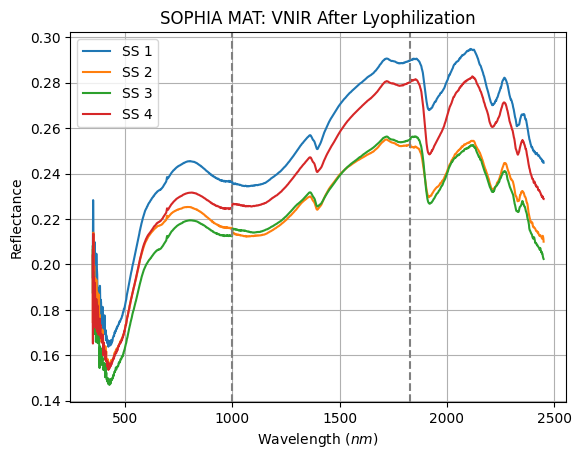

In [79]:
plot_vnir_after(sample='SOPHIA MAT', showAll=True)

Choosing SS 1 - smallest spectral joins

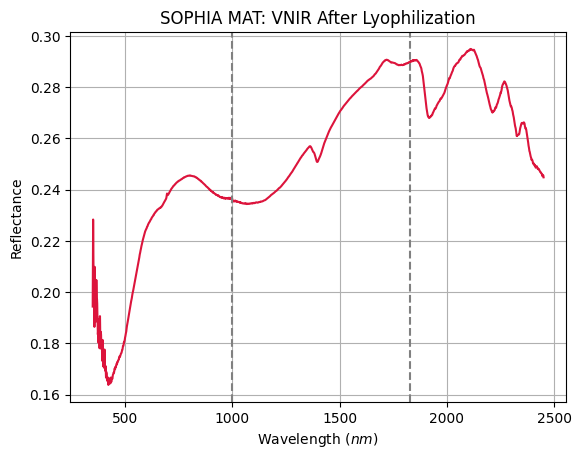

In [80]:
SELECTED_SUBSAMPLES['AFTER_VNIR']['SOPHIA MAT'] = 1
plot_vnir_after(sample='SOPHIA MAT')

##### Lyophilization Effects

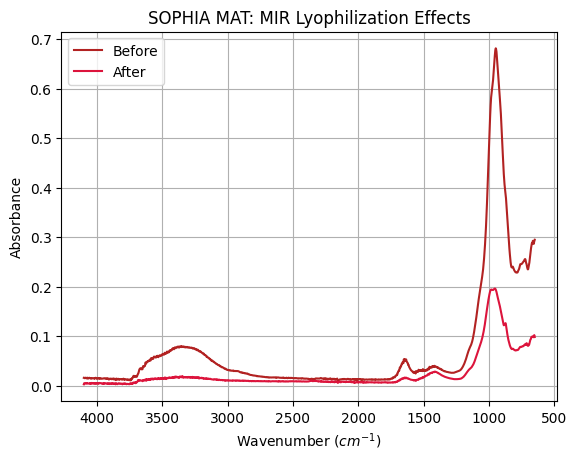

In [81]:
compare_subsamples(sample_A='SOPHIA MAT', sample_A_isBefore=True, isMIR=True)

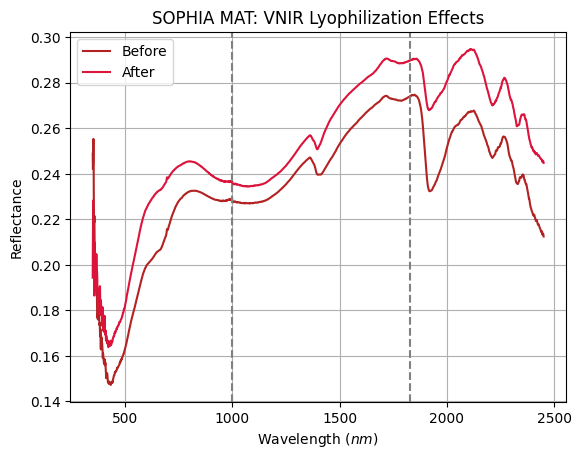

In [82]:
compare_subsamples(sample_A='SOPHIA MAT', sample_A_isBefore=True, isMIR=False)

In FTIR, the signal after lyophilization is smaller, in particular the $OH$ stretching at $3000cm^{-1} - 3700cm^{-1}$. The small features at $2900cm^{-1}$ ($CH_2$ stretching) and $1530cm^{-1}$ (amide II vibrational modes of proteins) are undetectable after lyophilzation. This suggests that the lyophilization process may hinder our ability to detect features related to some organic functional groups. However, the $1530cm^{-1}$ feature did not show up in all subsamples for SCOTT MAT and only showed a strong presence in one subsample before lyophilization, so more data would be useful to confirm that the lyophilization process is the reason for this feature not being present. The $874cm^{-1}$ feature detected in the SCOTT MAT sample due to $C-O$ stretch was not present in the SOPHIA MAT sample before lyophilization, but we see that this feature can be detected after the lyophilization process. This suggests that lyophilization may actually enable us to detect more organic features within minerals.

In VNIR, lyophilization did not affect our ability to detect any of the features, but there is a notable decrease in the intensity of the $1400nm$ and $1900nm$. This suggests that these features are related to $OH$ virbrations in water, whereas the $1700nm$ feature that does not decrease in intensity may arise from $OH$ vibrations in other minerals in SOPHIA or SCOTT MAT.

Further work is required to explore the reasons behind different features being visible before and after lyophilization and to confirm whether lyophilization is the cause of this.

#### SOPHIA Comparisons

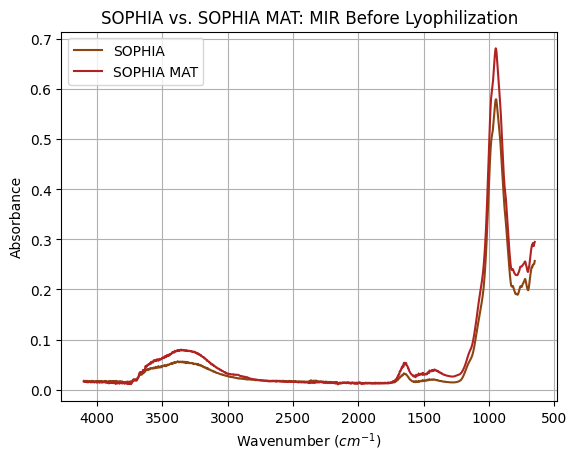

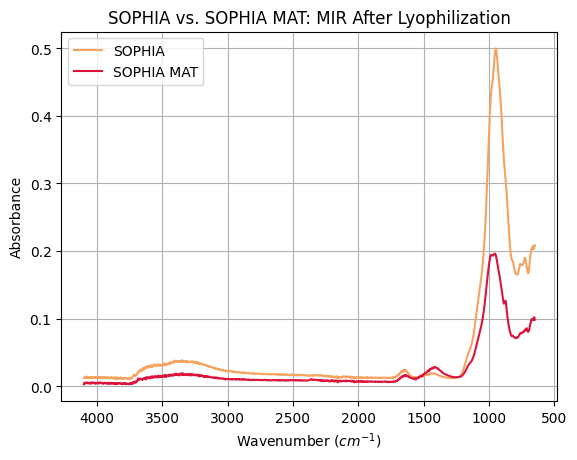

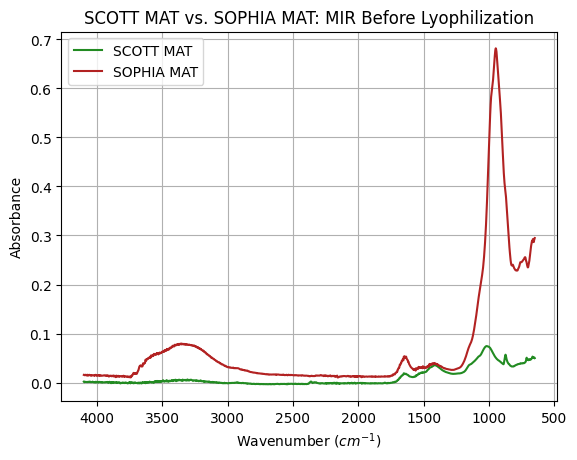

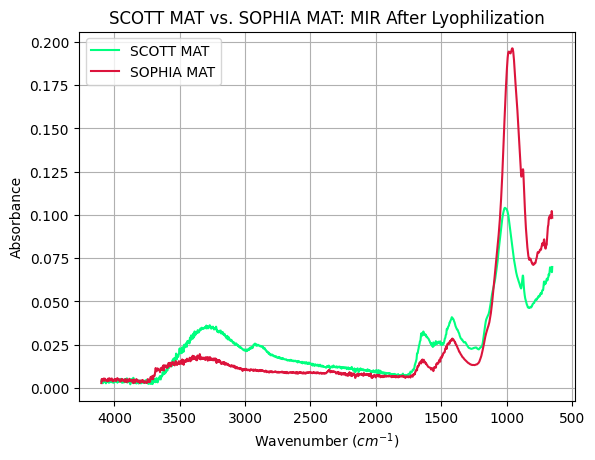

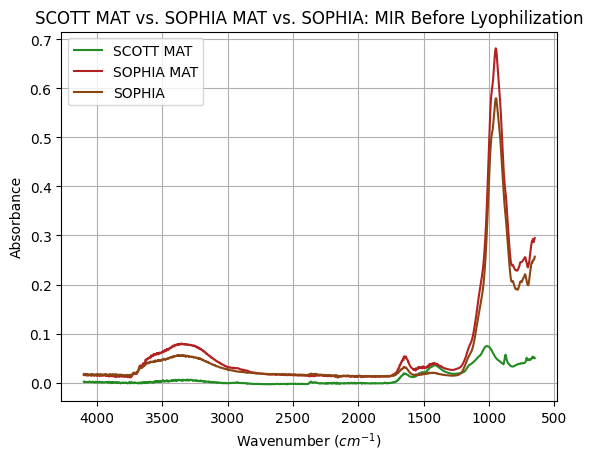

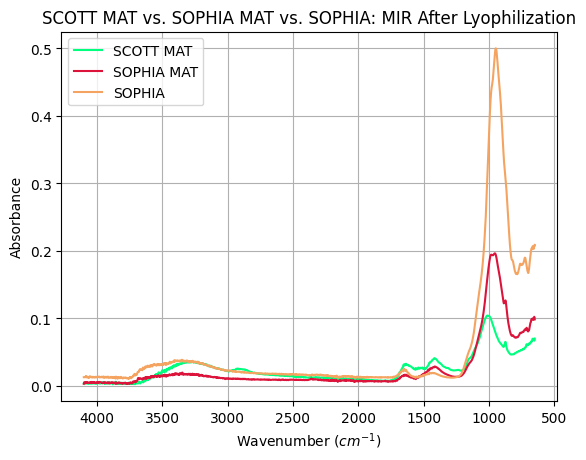

In [83]:
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=True, sample_B_isBefore=True, sample_C_isBefore=True, isMIR=True)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=False, sample_B_isBefore=False, sample_C_isBefore=False, isMIR=True)

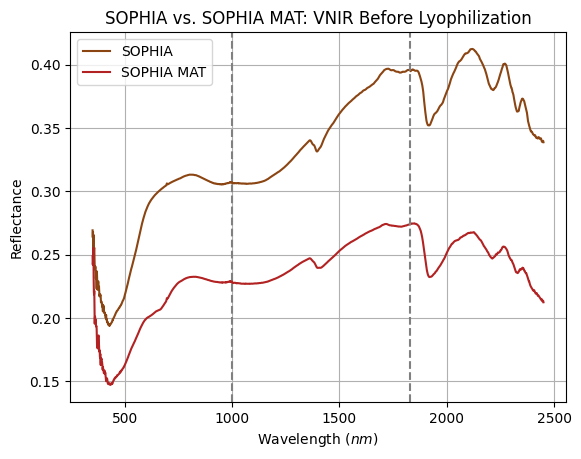

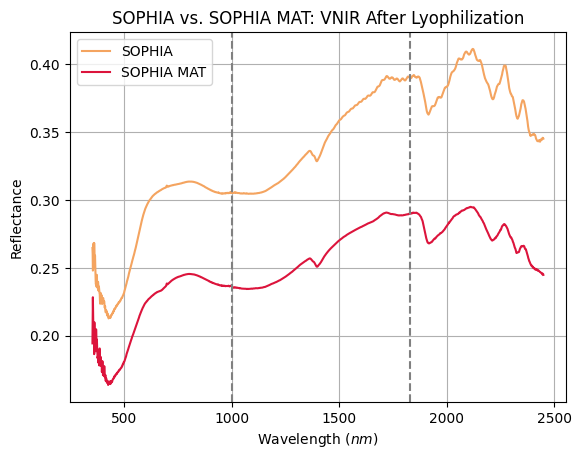

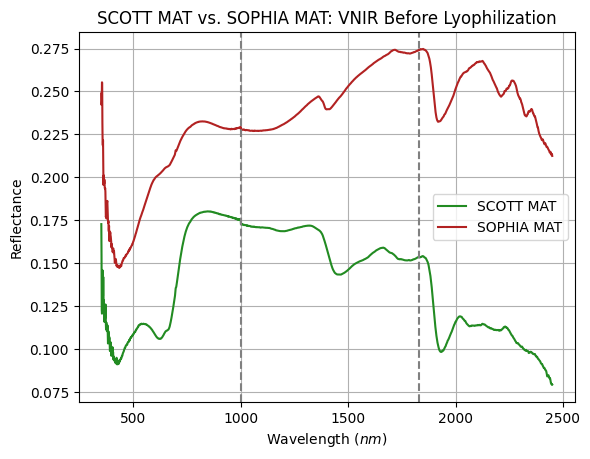

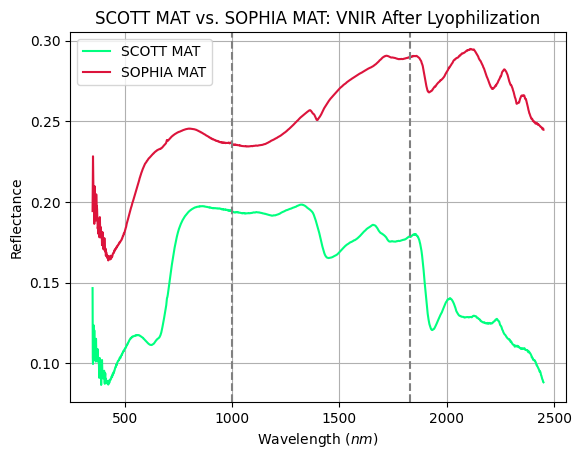

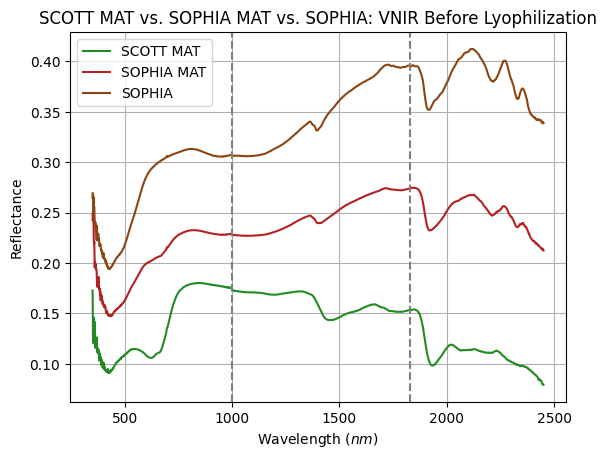

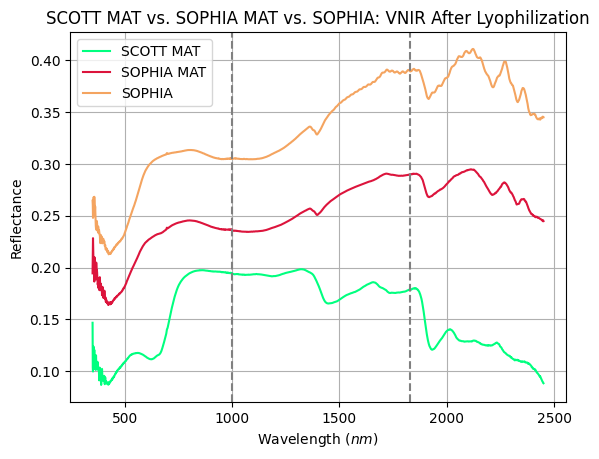

In [84]:
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='SOPHIA', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=True, sample_B_isBefore=True, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_A_isBefore=False, sample_B_isBefore=False, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=True, sample_B_isBefore=True, sample_C_isBefore=True, isMIR=False)
compare_subsamples(sample_A='SCOTT MAT', sample_B='SOPHIA MAT', sample_C='SOPHIA', sample_A_isBefore=False, sample_B_isBefore=False, sample_C_isBefore=False, isMIR=False)